<div class="alert alert-block alert-success">
    
# FIT5196 Assessment 2
#### Student Name:  Michelle Fong

Environment: Google Colab
    
</div>

<div class="alert alert-block alert-danger">
    
## Table of Contents

</div>    

[1. Task 1](#Task1) <br>
$\;\;\;\;$[1.1. Dirty](#Dirty) <br>
$\;\;\;\;$[1.2. Outlier](#Outlier) <br>
$\;\;\;\;$[1.3. Missing](#Missing) <br>
[2. Task 2](#Task2) <br>
[3. References](#Ref) <br>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

<div class="alert alert-block alert-warning">

# 1. Task 1  <a class="Task1" name="Task1"></a>
    
</div>

This task is to explore and understand the given data through various data cleansing process. Each part focus on a distinct aspect of data quality:
 - Dirty data: Detect and fix errors to ensure it aligns with schema
 - Missing data: Impute the missing data and evaluate the accuracy of the imputation using R^2
 - Outlier data: Dectect and remove the outlier, and compare the visualization before and after removal.

The dataset are shared between 3 parts with slight difference depends on their focus. The dataset is about Food Delivery data from a restaurant in Melbourne, Aus, and has a dimension of 500 x 12, with the target variable being the delivery fee.

## Loading data

In [ ]:
path = '/content/drive/Shareddrives/FIT5196_S1_2024/A2/student_data/'

dirty_df = pd.read_csv(path + 'dirty_data.csv')
missing_df = pd.read_csv(path + 'missing_data.csv')
outlier_df = pd.read_csv(path + 'outlier_data.csv')

In [ ]:
branch = pd.read_csv("/content/drive/Shareddrives/FIT5196_S1_2024/A2/supplementary_data/branches.csv")
edges = pd.read_csv("/content/drive/Shareddrives/FIT5196_S1_2024/A2/supplementary_data/edges.csv")
nodes = pd.read_csv("/content/drive/Shareddrives/FIT5196_S1_2024/A2/supplementary_data/nodes.csv")

In [ ]:
dirty_df.shape, missing_df.shape, outlier_df.shape

((500, 12), (500, 12), (500, 12))

<div class="alert alert-block alert-warning">

## 1.1 Dirty  <a class="Dirty" name="Dirty"></a>
    
</div>

The objective of this part is to detect and correct errors in the dataset to ensure it aligns with the defined format and datatypes. The expected outcome of this part is a cleaned dataset free from errors and inconsistencies, ready for further analysis. Below are some preliminary check and several issues have been identified.

- Incorrect Datatypes: some attributes like date and time are not in the correct format

In [ ]:
dirty_df.dtypes

order_id                    object
date                        object
time                        object
order_type                  object
branch_code                 object
order_items                 object
order_price                float64
customer_lat               float64
customer_lon               float64
customerHasloyalty?          int64
distance_to_customer_KM    float64
delivery_fee               float64
dtype: object

- Inconsistency in capitalizaiton: Attributes like `branch_code` have inconsistenct capitalization.

In [ ]:
dirty_df.head(5)

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
0,ORDK07260,2018-05-25,12:43:56,Lunch,bk,"[('Fries', 3), ('Burger', 9)]",315.00,-37.803539,144.994473,0,5.258,10.687348
1,ORDK07367,2018-15-02,09:21:07,Breakfast,BK,"[('Pancake', 3), ('Cereal', 7), ('Coffee', 10)...",316.75,-37.814505,144.999917,0,4.488,9.531639
2,ORDI08157,10-03-2018,10:11:49,Breakfast,NS,"[('Eggs', 9), ('Cereal', 9), ('Coffee', 7), ('...",657.75,-37.825089,144.982162,0,9.407,16.595430
3,ORDY02780,2018-08-24,15:46:28,Dinner,TP,"[('Chicken', 8), ('Steak', 2), ('Salad', 6), (...",616.20,-37.820519,144.951119,0,8.648,11.565328
4,ORDI03952,2018-11-06,18:08:27,Breakfast,NS,"[('Fish&Chips', 1), ('Salmon', 6)]",281.00,-37.815208,144.963443,0,8.164,14.546491


In [ ]:
print('Number of duplicated row: ', dirty_df.duplicated().sum())

Number of duplicated row:  0


Above code confirmed there is no duplicated rows in the dataframe.

The next step involves thoroughly investigating each row to ensure it is free from errors.

### order_id

First we checked if the order_id is indeed unique across all rows and has a freqency of 1:


In [ ]:
# check if the id is unique
dirty_df.order_id.describe()

count           500
unique          500
top       ORDK07260
freq              1
Name: order_id, dtype: object

### date, time

To standardize the format fo the date records, a funciton `clean_date` was defined to re-arrange the date order with various formats found in the original dataframe. The funciton splits the date by '-', then re-arranges the part into the format YYYY-MM-DD. If the last part has a length of 4, it is detected as year. If the middle part is greater than 12, it was detected as the month. If both month and day are less than 12, the function leaves the date records as it is since we can identify it that is an mistake. Then the date columns was specified as datetime [1].


In [ ]:
# date format
def clean_date(date):
    parts = date.split('-')
    if len(parts) == 3:
        # last part = year
        if len(parts[2]) == 4:
            return '-'.join([parts[2], parts[1], parts[0]]) # yyyy-mm-dd

        # middle part > 12 = day
        elif int(parts[1]) > 12:
            return '-'.join([parts[0], parts[2], parts[1]])
    return date

dirty_df['date'] = dirty_df['date'].apply(clean_date)
# format check
dirty_df['date'] = pd.to_datetime(dirty_df['date'],format='%Y-%m-%d')


In [ ]:
dirty_df.dtypes

order_id                           object
date                       datetime64[ns]
time                               object
order_type                         object
branch_code                        object
order_items                        object
order_price                       float64
customer_lat                      float64
customer_lon                      float64
customerHasloyalty?                 int64
distance_to_customer_KM           float64
delivery_fee                      float64
dtype: object

### order_type, branch_code, loyalty

In the next step, the column `order_type`, `branch_code`, and loyalty were specified as categorical variables with predefined levels to ensure consistency. To prevent inconsistencies or missing value creation during the conversion to categorical, all records in the branch_code column were capitalized.

Afterwards, the number of  occurrences for each level in `branch_code` was counted to confirm that only three levels exist: 'NS', 'TP', and 'BK'. Similarly, the levels for `order_type` were confirmed to be 'Breakfast', 'Lunch', and 'Dinner', while loyalty was found to have two levels: 0 and 1.

`order_price` column was specified as a float to ensure numerical consistency.

In [ ]:
# order_type
dirty_df['order_type'] = pd.Categorical(dirty_df['order_type'],
                                     categories=['Breakfast', 'Lunch', 'Dinner'])

# branch_code
dirty_df['branch_code'] = dirty_df['branch_code'].str.upper()

dirty_df['branch_code'] = pd.Categorical(dirty_df['branch_code'],
                                     categories=['NS', 'TP', 'BK'])

print(dirty_df['order_type'].value_counts(),
    dirty_df['branch_code'].value_counts())


order_type
Dinner       183
Breakfast    162
Lunch        155
Name: count, dtype: int64 branch_code
TP    169
NS    167
BK    164
Name: count, dtype: int64


In [ ]:
# order_price
dirty_df['order_price'] = dirty_df['order_price'].astype(float)
dirty_df.order_price.head(5)

# customerHasloyalty
dirty_df['customerHasloyalty?'].value_counts()

customerHasloyalty?
0    426
1     74
Name: count, dtype: int64

After further examination, it was discovered that there was inconsistency between the recorded `time` and the `order_type`. According to the provided document, the time periods for each order type are defined as: Breakfast from 8:00 AM to 12:00 PM, Lunch from 12:00 PM to 4:00 PM, and Dinner from 4:00 PM to 8:00 PM. However, some records in the dataset had `order_type` mismatched with time of day, such as Row 3 has a time of 3:00 PM but an order_type of 'Dinner'.

To address this inconsistency, the `time` column was converted into a datetime format with a format of HH:MM:SS, and the order_type was corrected based on the time of day.



In [ ]:
# wrong order_type
dirty_df['time'] = pd.to_datetime(dirty_df['time'],format='%H:%M:%S').dt.time
dirty_df.loc[(dirty_df['time'] >= pd.to_datetime('08:00:00').time()) & (dirty_df['time'] < pd.to_datetime('12:00:00').time()), 'order_type'] = 'Breakfast'
dirty_df.loc[(dirty_df['time'] >= pd.to_datetime('12:00:01').time()) & (dirty_df['time'] < pd.to_datetime('16:00:00').time()), 'order_type'] = 'Lunch'
dirty_df.loc[(dirty_df['time'] >= pd.to_datetime('16:00:01').time()) & (dirty_df['time'] < pd.to_datetime('20:00:00').time()), 'order_type'] = 'Dinner'

# Convert order_type to categorical
dirty_df['order_type'] = pd.Categorical(dirty_df['order_type'], categories=['Breakfast', 'Lunch', 'Dinner'])



In [ ]:
print(dirty_df['order_type'].value_counts())

order_type
Dinner       177
Lunch        167
Breakfast    156
Name: count, dtype: int64


In [ ]:
dirty_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   order_id                 500 non-null    object        
 1   date                     500 non-null    datetime64[ns]
 2   time                     500 non-null    object        
 3   order_type               500 non-null    category      
 4   branch_code              500 non-null    category      
 5   order_items              500 non-null    object        
 6   order_price              500 non-null    float64       
 7   customer_lat             500 non-null    float64       
 8   customer_lon             500 non-null    float64       
 9   customerHasloyalty?      500 non-null    int64         
 10  distance_to_customer_KM  500 non-null    float64       
 11  delivery_fee             500 non-null    float64       
dtypes: category(2), datetime64[ns](1), f

In [ ]:
dirty_df.head(10)

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
0,ORDK07260,2018-05-25,12:43:56,Lunch,BK,"[('Fries', 3), ('Burger', 9)]",315.00,-37.803539,144.994473,0,5.258,10.687348
1,ORDK07367,2018-02-15,09:21:07,Breakfast,BK,"[('Pancake', 3), ('Cereal', 7), ('Coffee', 10)...",316.75,-37.814505,144.999917,0,4.488,9.531639
2,ORDI08157,2018-03-10,10:11:49,Breakfast,NS,"[('Eggs', 9), ('Cereal', 9), ('Coffee', 7), ('...",657.75,-37.825089,144.982162,0,9.407,16.595430
3,ORDY02780,2018-08-24,15:46:28,Lunch,TP,"[('Chicken', 8), ('Steak', 2), ('Salad', 6), (...",616.20,-37.820519,144.951119,0,8.648,11.565328
4,ORDI03952,2018-11-06,18:08:27,Dinner,NS,"[('Fish&Chips', 1), ('Salmon', 6)]",281.00,-37.815208,144.963443,0,8.164,14.546491
5,ORDB10005,2018-10-26,17:48:10,Dinner,TP,"[('Pasta', 1), ('Shrimp', 3), ('Salmon', 9), (...",803.50,-37.820504,144.965820,0,7.434,11.842687
6,ORDJ01270,2018-12-14,19:29:34,Dinner,TP,"[('Shrimp', 4), ('Pasta', 5), ('Fish&Chips', 6)]",563.50,-37.801004,144.962895,0,9.683,13.419896
7,ORDJ10202,2018-10-18,17:38:01,Dinner,TP,"[('Salmon', 6), ('Eggs', 10), ('Shrimp', 9), (...",1164.50,-37.802181,144.948735,0,10.112,14.069506
8,ORDA04939,2018-02-13,09:21:07,Breakfast,BK,"[('Coffee', 3), ('Eggs', 2)]",66.50,-37.824947,144.992286,0,9.429,11.673844
9,ORDJ06881,2018-04-13,11:22:49,Breakfast,TP,"[('Pancake', 10), ('Eggs', 10), ('Cereal', 7)]",609.50,-37.802149,144.944280,0,10.427,12.642051


### use missing and outlier to correct price and item

Based on the document, each `order_type` should have a distinct set of items. However, some items were found to appear in more than one `order_type`. For instance, 'Eggs' appeared in both Dinner (row 7) and Breakfast (row 3). Since the `order_price` is calculated based on the `order_type`, both columns need to be corrected.

**Steps:**  
To address this issue, the incorrect items are first removed, and then the order_price is recalculated. A function `filter_item` was defined to implement these steps and it was applied to the original datafram [2].


To remove the incorrect items, a dictionary of the menu is created with the keys representing the `order_type` and the values containing the distinct corresponding items, using correct data from missing_df and outlier_df. Then, the dirty_df is split into two dataframes: corr_order for correct orders and wrong_order for orders containing wrong items. It was found that 37 records contain wrong items.


In [ ]:
# use missing & outlier to calcuate the unit price
missing_outlier = pd.concat([missing_df, outlier_df], axis = 0)
missing_outlier.head(5)

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
0,ORDK08164,2018-08-18,15:36:20,Lunch,NaN,"[('Salad', 1), ('Chicken', 1), ('Fries', 7), (...",381.20,-37.814270,145.011127,0,NaN,11.868106
1,ORDX05727,2018-10-10,17:17:44,Dinner,BK,"[('Pasta', 3), ('Shrimp', 6)]",406.50,-37.812897,144.951891,0,8.618,15.615692
2,ORDI04618,2018-01-04,08:00:00,Breakfast,NaN,"[('Cereal', 6), ('Coffee', 8), ('Eggs', 4), ('...",419.50,-37.803772,144.938021,1,NaN,7.641971
3,ORDI01160,2018-11-18,18:38:52,Dinner,NS,"[('Shrimp', 4), ('Salmon', 8), ('Fish&Chips', ...",746.50,-37.810718,145.002339,0,9.639,17.322643
4,ORDX02003,2018-04-19,11:32:57,Breakfast,BK,"[('Eggs', 4), ('Cereal', 7), ('Pancake', 1)]",259.25,-37.813101,144.973874,0,6.830,11.574648


In [ ]:
missing_outlier['order_items'] = missing_outlier['order_items'].apply(lambda x: eval(x))


all_items = []

# Iterate over each row
for index, row in missing_outlier.iterrows():
    order_type = row['order_type']
    order_items = row['order_items']
    all_items.extend([(order_type, item, quantity) for item, quantity in order_items])

menu = pd.DataFrame(all_items, columns=['order_type', 'item', 'quantity'])

# Group by order_type and item, and sum the quantities
menu = menu.groupby(['order_type', 'item']).agg({'quantity': 'sum'}).reset_index()

print(menu)

   order_type        item  quantity
0   Breakfast      Cereal      1304
1   Breakfast      Coffee      1367
2   Breakfast        Eggs      1405
3   Breakfast     Pancake      1455
4      Dinner  Fish&Chips      1440
5      Dinner       Pasta      1308
6      Dinner      Salmon      1463
7      Dinner      Shrimp      1365
8       Lunch      Burger      1214
9       Lunch     Chicken      1174
10      Lunch       Fries      1281
11      Lunch       Salad      1169
12      Lunch       Steak      1194


In [ ]:
# dict storing the distrinct item order_type:item
order_dict = {}
for order_type, item in zip(menu['order_type'], menu['item']):
    if order_type not in order_dict:
        order_dict[order_type] = [item]
    else:
        order_dict[order_type].append(item)

print(order_dict)

{'Breakfast': ['Cereal', 'Coffee', 'Eggs', 'Pancake'], 'Dinner': ['Fish&Chips', 'Pasta', 'Salmon', 'Shrimp'], 'Lunch': ['Burger', 'Chicken', 'Fries', 'Salad', 'Steak']}


In [ ]:
dirty_df['order_items'] = dirty_df['order_items'].apply(lambda x: eval(x))

In [ ]:
# filter out order with corr order_items
corr_order = []
wrong_order = []

for index, row in dirty_df.iterrows():
    order_id = row['order_id']
    order_type = row['order_type']
    order_items = row['order_items']
    order_price = row['order_price']
    valid_items = [item for item, _ in order_items if item in order_dict.get(order_type, [])]
    # Check if the number of valid items matches the number of items in the original order
    if len(valid_items) == len(order_items):
        corr_order.append({'order_id':order_id,
                           'order_type': order_type,
                           'order_items': order_items,
                           'order_price': order_price})
    else:
        wrong_order.append({'order_id':order_id,
                            'order_type': order_type,
                            'order_items': order_items,
                            'order_price': order_price})

corr_df = pd.DataFrame(corr_order)
# shape: (463, 4)
corr_df.head(5)

,order_id,order_type,order_items,order_price
0,ORDK07260,Lunch,"[(Fries, 3), (Burger, 9)]",315.00
1,ORDK07367,Breakfast,"[(Pancake, 3), (Cereal, 7), (Coffee, 10), (Egg...",316.75
2,ORDI08157,Breakfast,"[(Eggs, 9), (Cereal, 9), (Coffee, 7), (Pancake...",657.75
3,ORDY02780,Lunch,"[(Chicken, 8), (Steak, 2), (Salad, 6), (Burger...",616.20
4,ORDI03952,Dinner,"[(Fish&Chips, 1), (Salmon, 6)]",281.00


In [ ]:
wrong_df = pd.DataFrame(wrong_order)
# shape: (37, 4)
wrong_df[:5]
        #'Dinner': ['Fish&Chips', 'Pasta', 'Salmon'

,order_id,order_type,order_items,order_price
0,ORDJ10202,Dinner,"[(Salmon, 6), (Eggs, 10), (Shrimp, 9), (Pasta,...",1164.50
1,ORDB03445,Breakfast,"[(Coffee, 1), (Fish&Chips, 10), (Pancake, 3), ...",426.25
2,ORDC09796,Lunch,"[(Salad, 10), (Pancake, 6), (Burger, 7)]",581.00
3,ORDB04738,Dinner,"[(Fish&Chips, 3), (Salmon, 7), (Fries, 6)]",716.00
4,ORDI01516,Breakfast,"[(Eggs, 7), (Cereal, 3), (Salmon, 7)]",269.50


### unit_price


**Calculate Unit Price:**  
Using missing_df and outlier_df, the unit price of each item is computed using `np.linalg.lstsq` [3]. `A` is an array with dimensions 1000 x 13, where rows represent the total number of records in missing_df and outlier_df, and columns represent the number of items across all order_type. `b` is an array storing the order_price of all records. The calculated unit prices are stored in a dictionary with keys representing the item and values representing the unit price.

Using this dictionary, the `order_price` is computed by multiplying the unit price by the quantity.

We also attempted to use `np.linalg.solve` [4] to compute the unit price, and we obtained the same result. However, `np.linalg.lstsq` is more straighforward with only one line of code requried. `np.linalg.solve` requires several steps involving transformation and transpose etc to calculate the price. Therefore it was used to double-check the reuslt of `np.linalg.lstsq`.

Additional information about how we calculate the unit price with `np.linalg.solve `:

When implement `np.linalg.solve ` to slove the least square questions [5], there are some preparation need to be done.
First, we need to create a indentity matrix with `eye` [6] function, and transpose A (order items with the quantity, m*n matrix) for calulation usage.
Then, we calcaute the ATA and ATb to get the sum of the squares of `the quantities of item across all orders`, and the weighted sum of `the order price` separately.
Finally, we can use normal equations to solve the problem and get the unit price.

In [ ]:
# get unique items
unique_items = set()
for order in dirty_df['order_items']:
    for item, quantity in order:
        unique_items.add(item)

# for calcultaion
A = []
b = []

# get order vector
for index, row in missing_outlier.iterrows():
    order_items = row['order_items']
    order_price = row["order_price"]
    order_vector = []

    # get square matrix
    for item in unique_items:
        order_vector.append(sum(qty for i, qty in order_items if i == item))

    A.append(order_vector)
    b.append(order_price)

# convert A & b to array
A = np.array(A)
b = np.array(b)

In [ ]:
A.shape, b.shape

((1000, 13), (1000,))

In [ ]:
# Assuming A and b are properly defined
unit_prices, residuals, rank, singular_values = np.linalg.lstsq(A, b, rcond=None)

unit_price_dict = {}

for i, item in enumerate(unique_items):
    unit_price_dict[item] = round(unit_prices[i], 2)

print(unit_price_dict)

{'Pasta': 27.5, 'Chicken': 32.0, 'Cereal': 21.0, 'Fish&Chips': 35.0, 'Shrimp': 54.0, 'Pancake': 24.25, 'Coffee': 7.5, 'Eggs': 22.0, 'Steak': 45.0, 'Burger': 31.0, 'Salmon': 41.0, 'Salad': 17.2, 'Fries': 12.0}


In [ ]:
corr_df.head(1)

,order_id,order_type,order_items,order_price
0,ORDK07260,Lunch,"[(Fries, 3), (Burger, 9)]",315.0


In [ ]:
# testing the unit_price found
order = {'Fries': 3,
         'Burger': 9}

# Calculate total price
total_price = sum(order[item] * unit_price_dict[item] for item in order)

print("Total Price:", total_price)

Total Price: 315.0


In [ ]:
# Create a function to filter out items based on order_dict
def filter_items(row):
    order_type = row['order_type']
    order_items = row['order_items']

    # step 1: delete wrong item
    filtered_items = [(item, quantity) for item, quantity in order_items if item in order_dict[order_type]]

    # step 2: recalculate the order price
    order_price = sum(unit_price_dict[item] * quantity for item, quantity in filtered_items)
    return filtered_items, order_price

# apply on dirty_df and treat the result as col & update the corr col
dirty_df[['order_items', 'order_price']] = dirty_df.apply(filter_items, axis=1, result_type='expand')
dirty_df[:5]
    # wrong_df
    #0	ORDJ10202	Dinner	[(Salmon, 6), (Eggs, 10), (Shrimp, 9), (Pasta, 3)]	1164.50

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
0,ORDK07260,2018-05-25,12:43:56,Lunch,BK,"[(Fries, 3), (Burger, 9)]",315.00,-37.803539,144.994473,0,5.258,10.687348
1,ORDK07367,2018-02-15,09:21:07,Breakfast,BK,"[(Pancake, 3), (Cereal, 7), (Coffee, 10), (Egg...",316.75,-37.814505,144.999917,0,4.488,9.531639
2,ORDI08157,2018-03-10,10:11:49,Breakfast,NS,"[(Eggs, 9), (Cereal, 9), (Coffee, 7), (Pancake...",657.75,-37.825089,144.982162,0,9.407,16.595430
3,ORDY02780,2018-08-24,15:46:28,Lunch,TP,"[(Chicken, 8), (Steak, 2), (Salad, 6), (Burger...",616.20,-37.820519,144.951119,0,8.648,11.565328
4,ORDI03952,2018-11-06,18:08:27,Dinner,NS,"[(Fish&Chips, 1), (Salmon, 6)]",281.00,-37.815208,144.963443,0,8.164,14.546491


To check the result, one example from the wrong_df (`order_id`: 'ORDJ10202') is used for validation. It has 4 items originally and an order_price of 1164.5. After cleansing, it had 3 items only and an order_price of 814.5 in dirty_df.

In [ ]:
dirty_df.loc[dirty_df['order_id'] == 'ORDJ10202']

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
7,ORDJ10202,2018-10-18,17:38:01,Dinner,TP,"[(Salmon, 6), (Shrimp, 9), (Pasta, 3)]",814.5,-37.802181,144.948735,0,10.112,14.069506


In [ ]:
wrong_df[:1]

,order_id,order_type,order_items,order_price
0,ORDJ10202,Dinner,"[(Salmon, 6), (Eggs, 10), (Shrimp, 9), (Pasta,...",1164.5


In [ ]:
dirty_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   order_id                 500 non-null    object        
 1   date                     500 non-null    datetime64[ns]
 2   time                     500 non-null    object        
 3   order_type               500 non-null    category      
 4   branch_code              500 non-null    category      
 5   order_items              500 non-null    object        
 6   order_price              500 non-null    float64       
 7   customer_lat             500 non-null    float64       
 8   customer_lon             500 non-null    float64       
 9   customerHasloyalty?      500 non-null    int64         
 10  distance_to_customer_KM  500 non-null    float64       
 11  delivery_fee             500 non-null    float64       
dtypes: category(2), datetime64[ns](1), f

### customer_lon, customer_lat

Upon further inspection, inconsistencies were also discovered in the `customer_lat` and `customer_long` columns. Given that the dataset describe information about Food Delivery data from a restaurant in Melbourne, Australia, the longitude and latitude values should be fairly similar. However, it was observed that the longitude values ranged from -37.822545 to 145.026637, indicating errors that longitude and latitude values were mistakenly entered in reverse.

To correct this, latitude column was checked if it was greater than 100, which indicated  data entered wrongly. Those records were swapped with the corresponding values in the `customer_long` column.

After the swapping process, it was noticed that some records had positive latitude values, whereas Melbourne has a negative latitude. To handle this, these records were multiplied by -1.

In [ ]:
dirty_df.customer_lon.describe()

count    500.000000
mean     143.505156
std       16.299426
min      -37.822545
25%      144.952283
50%      144.963810
75%      144.982848
max      145.026637
Name: customer_lon, dtype: float64

In [ ]:
# take abs of long and lat
dirty_df['customer_lon'] = abs(dirty_df['customer_lon'])
dirty_df['customer_lat'] = abs(dirty_df['customer_lat'])

dirty_df.loc[dirty_df['customer_lon'] < 100, ['customer_lon', 'customer_lat']] = dirty_df.loc[dirty_df['customer_lon'] < 100, ['customer_lat', 'customer_lon']].values
dirty_df.loc[dirty_df['customer_lat'] > 100, ['customer_lon', 'customer_lat']] = dirty_df.loc[dirty_df['customer_lat'] > 100, ['customer_lat', 'customer_lon']].values

In [ ]:
dirty_df.customer_lon.describe()

count    500.000000
mean     144.967490
std        0.021231
min      144.917105
25%      144.952456
50%      144.964136
75%      144.982861
max      145.026637
Name: customer_lon, dtype: float64

In [ ]:
dirty_df['customer_lat'] *= -1
dirty_df.customer_lat.describe()

count    500.000000
mean     -37.812860
std        0.007652
min      -37.833164
25%      -37.819145
50%      -37.813368
75%      -37.806223
max      -37.791144
Name: customer_lat, dtype: float64

In [ ]:
dirty_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   order_id                 500 non-null    object        
 1   date                     500 non-null    datetime64[ns]
 2   time                     500 non-null    object        
 3   order_type               500 non-null    category      
 4   branch_code              500 non-null    category      
 5   order_items              500 non-null    object        
 6   order_price              500 non-null    float64       
 7   customer_lat             500 non-null    float64       
 8   customer_lon             500 non-null    float64       
 9   customerHasloyalty?      500 non-null    int64         
 10  distance_to_customer_KM  500 non-null    float64       
 11  delivery_fee             500 non-null    float64       
dtypes: category(2), datetime64[ns](1), f

In [ ]:
dirty_df

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
0,ORDK07260,2018-05-25,12:43:56,Lunch,BK,"[(Fries, 3), (Burger, 9)]",315.00,-37.803539,144.994473,0,5.258,10.687348
1,ORDK07367,2018-02-15,09:21:07,Breakfast,BK,"[(Pancake, 3), (Cereal, 7), (Coffee, 10), (Egg...",316.75,-37.814505,144.999917,0,4.488,9.531639
2,ORDI08157,2018-03-10,10:11:49,Breakfast,NS,"[(Eggs, 9), (Cereal, 9), (Coffee, 7), (Pancake...",657.75,-37.825089,144.982162,0,9.407,16.595430
3,ORDY02780,2018-08-24,15:46:28,Lunch,TP,"[(Chicken, 8), (Steak, 2), (Salad, 6), (Burger...",616.20,-37.820519,144.951119,0,8.648,11.565328
4,ORDI03952,2018-11-06,18:08:27,Dinner,NS,"[(Fish&Chips, 1), (Salmon, 6)]",281.00,-37.815208,144.963443,0,8.164,14.546491
...,...,...,...,...,...,...,...,...,...,...,...,...
495,ORDX01334,2018-10-30,17:58:18,Dinner,BK,"[(Shrimp, 1), (Pasta, 10), (Salmon, 6)]",575.00,-37.806147,144.939898,0,10.123,17.540347
496,ORDZ04977,2018-07-20,14:35:29,Lunch,NS,"[(Burger, 5), (Fries, 1)]",167.00,-37.822177,144.947745,0,9.947,15.594014
497,ORDX05771,2018-12-21,19:49:51,Dinner,BK,"[(Pasta, 6), (Salmon, 2), (Shrimp, 7)]",625.00,-37.824432,144.988745,0,9.989,13.406677
498,ORDB04772,2018-05-05,12:03:22,Lunch,NS,"[(Burger, 1), (Steak, 3)]",166.00,-37.819620,144.994368,0,10.126,14.601939


In [ ]:
dirty_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   order_id                 500 non-null    object        
 1   date                     500 non-null    datetime64[ns]
 2   time                     500 non-null    object        
 3   order_type               500 non-null    category      
 4   branch_code              500 non-null    category      
 5   order_items              500 non-null    object        
 6   order_price              500 non-null    float64       
 7   customer_lat             500 non-null    float64       
 8   customer_lon             500 non-null    float64       
 9   customerHasloyalty?      500 non-null    category      
 10  distance_to_customer_KM  500 non-null    float64       
 11  delivery_fee             500 non-null    float64       
dtypes: category(3), datetime64[ns](1), f

In [ ]:
# save to file
dirty_df.to_csv("015_dirty_data_solution.csv", index=False)

### Conclusion

To summarize, in the dirty data, several inconsistencies were identified and handled, and each column was double-checked to confirm it was in the proper form:

1. order_id:
    - Error: No error found.
    - Action: Each ID is unique, and there are no duplicates.

2. date:
    - Error: Inconsistent format found.
    - Action: Created clean_date to unify the format to YYYY-MM-DD and ensured correct datatype.

3. time:
    - Error: No error found.
    - Action: Checked to align with the format HH:MM:SS.

4. order_type:
    - Error: Wrong data type, inconsistent with time.
    - Action: Specified as categorical with defined levels and refined the type based on time.

5. branch_code:
    - Error: Wrong data type, inconsistent capitalization, mismatch branch code with first 4 charaters in order id.
    - Action: Specified as categorical with defined levels, capitalized all records, and update the brach code into correct one.

6. order_item:
    - Error: Items were distinct to order_type.
    - Action: Removed wrong items based on order_type.

7. order_price:
    - Error: Wrong value due to including wrong items in order_item.
    - Action: Found the unit price of each item and recomputed the correct price.

8. customer_lat, customer_lon:
    - Error: Values reversed and missing negative sign in some latitudes.
    - Action: Reversed values if customer_lon is less than 100 and multiplied customer_lat by -1 if positive.

This ensures the dataset was cleaned and consistent, ready for further analysis.

<div class="alert alert-block alert-warning">

## 1.2 Outlier  <a class="Outlier" name="Outlier"></a>
    
</div>

The objective of this part is to detect and handle outliers in the delivery fee column. When first approaching this part, a univariate method was employed. However, it was discovered that different results were obtained depending on the method used, and there was no standardized way to evaluate these results.

To address this issue, a multivariate approach was also explored using linear regression, where the residuals were used to define the outliers. The Mean Squared Error (MSE) was used to evaluate the effectiveness of this approach.

This comprehensive approach ensured that outliers in the delivery fee column were properly identified and handled.

Before implementation, some preliminary checks were done below. It was found there were some values in the upper end creating a small tail to the right although it was no strong enough to conclude they were outliers.

In [ ]:
fee = outlier_df["delivery_fee"]
fee.describe()

count    500.000000
mean      13.751819
std        2.822485
min        4.696466
25%       12.490892
50%       13.837902
75%       15.452551
max       25.235223
Name: delivery_fee, dtype: float64

In [ ]:
def plot(fee):
    # Boxplot
    plt.subplot(1, 2, 1)
    plt.boxplot(fee)
    plt.title('Box plot')
    plt.xlabel('Delivery Fee')
    plt.ylabel('Delivery Fee')

    # Density plot
    plt.subplot(1, 2, 2)
    sns.histplot(fee, kde=True)
    plt.title('Density')
    plt.xlabel('Delivery Fee')
    plt.ylabel('Density')

    plt.tight_layout()
    plt.show()

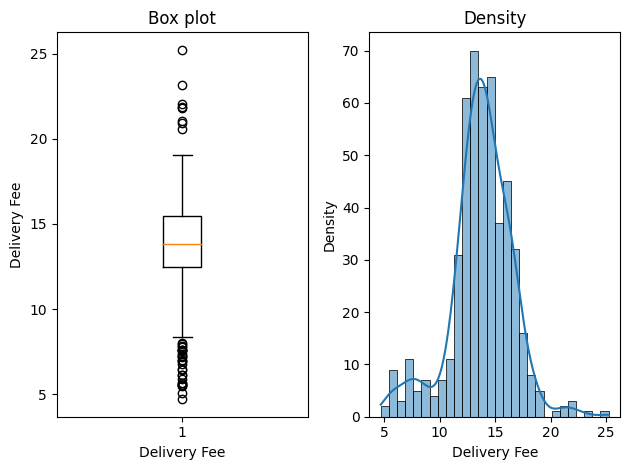

In [ ]:
plot(fee)

### Univariate

#### 3$σ$-rule

Firstly, outliers were identified by comparing the z-score of each record in the delivery fee column. Records that fell beyond 3 standard deviations from the mean were defined as outliers and they were removed. Using this method, a total of 4 records were removed.

From the generated graph, there were some records in the right tail being removed. However, there were still values contributing to the right tail of the distribution but we cannot confirm if they are also outlier.









In [ ]:
mean = fee.mean()
std = fee.std()

# Define outlier range
lower_bound = mean - 3 * std
upper_bound = mean + 3 * std

outliers = fee[(fee < lower_bound) | (fee > upper_bound)]


print("Outliers:")
print(outliers)
print(len(outliers))

Outliers:
2      23.138512
260     4.696466
265    25.235223
349     5.053965
Name: delivery_fee, dtype: float64
4


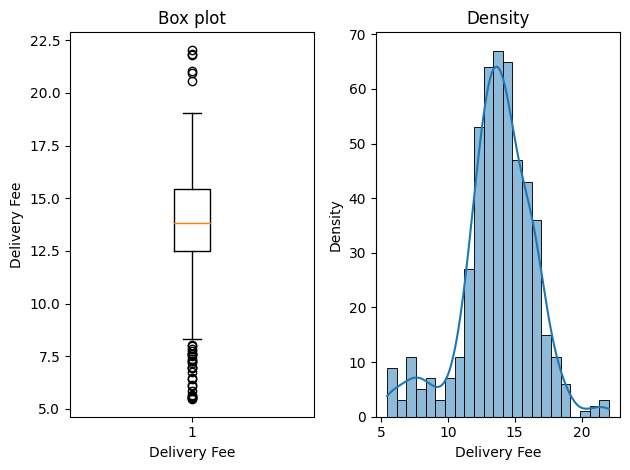

In [ ]:
removed_1 = outlier_df[~((outlier_df['delivery_fee'] < lower_bound) | (outlier_df['delivery_fee'] > upper_bound))]
plot(removed_1['delivery_fee'])

#### Hampel Identifier

Next, the Hampel identifier was employed to define outliers [1] by comparing the median. Using this method, a total of 48 records were removed.

In [ ]:
!pip install hampel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 1.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hampel: filename=hampel-1.0.2-cp310-cp310-linux_x86_64.whl size=209224 sha256=d1e8fd265e57a4dd0deefb2a0081ca03d08f4a2e298687ac37c7831d4a63033b
  Stored in directory: /root/.cache/pip/wheels/0e/c3/3c/8a9f55c3de0b09faf919393d4c6f09b11b7421dcaa7243b820
Successfully built hampel


In [ ]:
from hampel import hampel

# Apply the Hampel filter
outliers = hampel(fee).outlier_indices
outliers # index of the outliers

array([  5,  26,  62,  76,  88,  96, 121, 124, 141, 155, 156, 187, 191,
       201, 221, 223, 230, 234, 240, 241, 252, 265, 269, 271, 272, 277,
       294, 324, 332, 363, 376, 392, 405, 408, 414, 419, 424, 433, 435,
       442, 454, 459, 462, 468, 474, 477, 486, 489], dtype=int32)

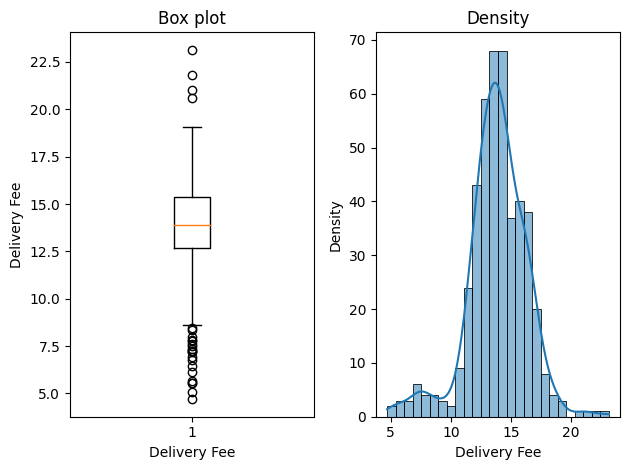

Number of outlier:  48
Size after removing outlier:  452


In [ ]:
removed_2 = fee.drop(outliers)
plot(removed_2)

print('Number of outlier: ', len(outliers))
print('Size after removing outlier: ', len(removed_2))

#### IQR

Next, the Interquartile Range (IQR) method was used to detect outliers. The range was defined by the upper and lower quartiles (Q3 and Q1), with records falling beyond 1.5 times the IQR were being removed.

With this method, 37 records were removed. Compared to the previous two methods, this approach removed all records with small and large values, contributing to the tails of the density plot.

In [ ]:
Q1 = fee.quantile(0.25)
Q3 = fee.quantile(0.75)
IQR = Q3 - Q1

# Define outlier range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = fee[(fee < lower_bound) | (fee > upper_bound)]

# Print outliers
print("Outliers:")
print(outliers)
print(len(outliers))

Outliers:
2      23.138512
62      6.941501
66     20.573464
69      7.192744
101     5.528486
102     7.965685
108     6.934046
110    21.787155
116     7.265515
155    20.946253
156     7.005728
187     8.013401
195     7.365383
201     5.860375
213     7.823766
225     5.549405
230     5.461131
256     7.611971
260     4.696466
265    25.235223
282    21.037773
284     5.636397
289     6.450360
310     6.117523
332     5.677089
335     7.258992
349     5.053965
414    21.855243
416     7.517694
424     6.113092
459     5.539822
462     6.407534
465     6.750500
468    22.046973
474     7.591514
477     7.616997
496     7.770714
Name: delivery_fee, dtype: float64
37


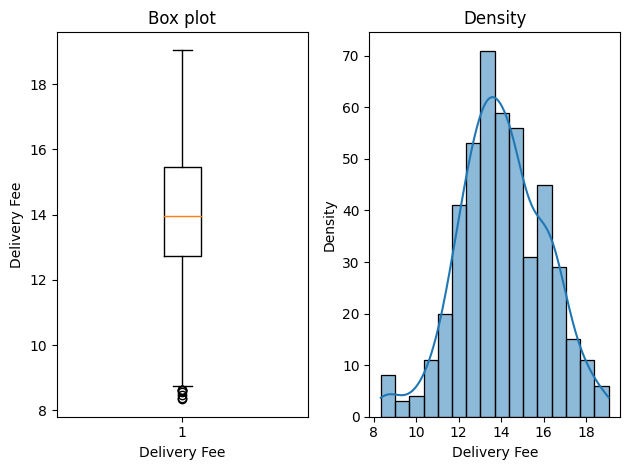

In [ ]:
removed_3 = outlier_df[~((outlier_df['delivery_fee'] < lower_bound) | (outlier_df['delivery_fee'] > upper_bound))]
plot(removed_3['delivery_fee'])

Using univariate methods above, some outliers were detected. However, the results cannot be evaluated properly to determine which are the best. Therefore a multivariate approach was also used.

### Mutlivariate

In this part, linear regression model was used to detect the outlier `branches`, `weekday_weekend`, `time_of_day`, and `distance_to_customer_KM` were used as features to predict the target variable `delivery_fee`.

`weekday_weekend` was derived from the `date` column to determine if it was a weekend order. `time_of_day` and `branches` were encoded and treated as categorical variables.

The dataset was split into 80% training data and 20% validation data. Using the original dataset, the Mean Squared Error (MSE) was calculated to be 5.9572181820261365.

The model was then applied to predict the delivery fee for all records in the outlier_df. Residual was defined as the difference between the predicted and observed delivery fee. Records with residuals greater than 3 were identified as outliers.

In this case, 37 records were classified as outliers, indicated by red dots in the scatter plot. Before removing the outliers, obvious tails were observed in the dataset.


In [ ]:
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
# weekday / weekend
outlier_df['weekday_weekend'] = pd.to_datetime(outlier_df['date']).dt.dayofweek.apply(lambda x: 1 if x >= 5 else 0)

# time of day
def encode_time_of_day(order_type):
    if order_type == 'Breakfast':
        return 0
    elif order_type == 'Lunch':
        return 1
    elif order_type == 'Dinner':
        return 2

outlier_df['time_of_day'] = outlier_df['order_type'].apply(encode_time_of_day)

# braches
# time of day
def encode_branch(branch_code):
    if branch_code == 'NS':
        return 0
    elif branch_code == 'TP':
        return 1
    elif branch_code == 'BK':
        return 2

outlier_df['branches'] = outlier_df['branch_code'].apply(encode_branch)
outlier_df


,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee,weekday_weekend,time_of_day,branches
0,ORDX01031,2018-08-14,15:26:11,Lunch,BK,"[('Fries', 5), ('Chicken', 3)]",156.00,-37.823000,144.964487,0,8.263,14.226515,0,1,2
1,ORDC00776,2018-06-24,13:44:47,Lunch,NS,"[('Salad', 3), ('Chicken', 7), ('Steak', 6), (...",820.60,-37.825240,144.982747,0,9.507,16.866997,1,1,0
2,ORDA06152,2018-02-23,09:41:24,Breakfast,BK,"[('Pancake', 7), ('Eggs', 8), ('Cereal', 10), ...",600.75,-37.806619,144.932422,0,10.360,23.138512,0,0,2
3,ORDA05018,2018-08-06,15:05:54,Lunch,BK,"[('Fries', 4), ('Steak', 9)]",453.00,-37.811974,144.986043,0,5.552,11.396133,0,1,2
4,ORDA00699,2018-04-24,11:43:05,Breakfast,BK,"[('Pancake', 5), ('Cereal', 6), ('Eggs', 8), (...",430.75,-37.811335,144.958376,0,8.392,13.553395,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,ORDY00021,2018-04-21,11:32:57,Breakfast,TP,"[('Pancake', 6), ('Coffee', 9)]",213.00,-37.818906,144.953085,0,8.532,12.050125,1,0,1
496,ORDX03407,2018-01-18,08:30:25,Breakfast,BK,"[('Eggs', 7), ('Cereal', 3)]",217.00,-37.823157,144.938236,1,10.332,7.770714,0,0,2
497,ORDX07032,2018-03-28,10:52:23,Breakfast,BK,"[('Cereal', 3), ('Coffee', 10), ('Eggs', 2)]",182.00,-37.812888,144.964137,0,7.648,12.700197,0,0,2
498,ORDX08594,2018-11-14,18:28:43,Dinner,BK,"[('Shrimp', 4), ('Salmon', 8), ('Fish&Chips', ...",779.00,-37.822395,144.947423,0,9.302,16.301999,0,2,2


In [ ]:
X = outlier_df[['branches','weekday_weekend', 'time_of_day', 'distance_to_customer_KM'] ]
y = outlier_df['delivery_fee']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# model training and fitting
model = LinearRegression()
model.fit(X_train, y_train)
predicted_fee = model.predict(X_test)


mse = mean_squared_error(y_test, predicted_fee)
print("Mean Squared Error:", mse)

Mean Squared Error: 5.9572181820261365


In [ ]:
predicted_fee = model.predict(X)
len(predicted_fee)

500

In [ ]:
import statsmodels.api as sm
residuals = fee - predicted_fee
outliers_resid = residuals[abs(residuals) > 3]
outliers_index = outliers_resid.index
len(outliers_index)

49

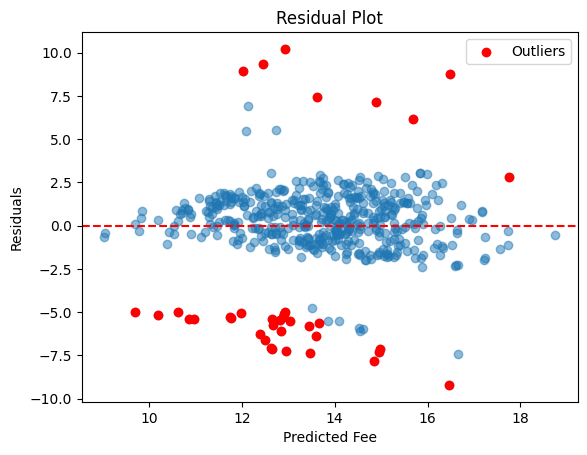

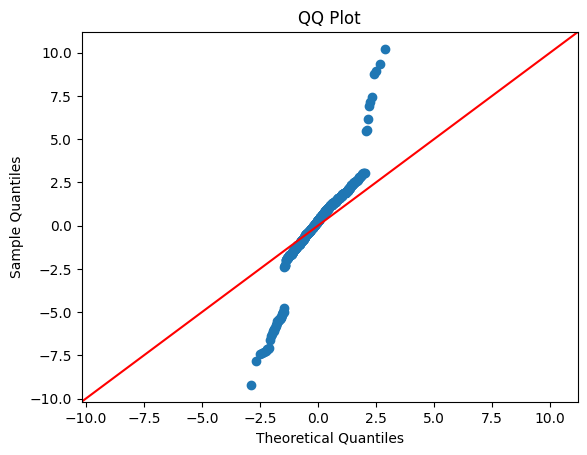

In [ ]:
# Residual plot
plt.scatter(predicted_fee, residuals, alpha=0.5)
# show the outliers
plt.scatter(predicted_fee[outliers.index],
            residuals[outliers.index],
            color='red', label='Outliers')
plt.title('Residual Plot')
plt.xlabel('Predicted Fee')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.legend()
plt.show()

# QQ Plot
sm.qqplot(residuals, line ='45')
plt.title('QQ Plot')
plt.show()


The identified outliers were removed from the outlier_df, and the updated scatter plot and QQ plot are displayed below.

All residuals of the predicted fee are less than 3, although the values of residuals appear to increase with the predicted fee. Despite this, the updated QQ plot looks significantly improved, with all dots close to the 45-degree line, indicating that the dataset is much closer to normal distribution.

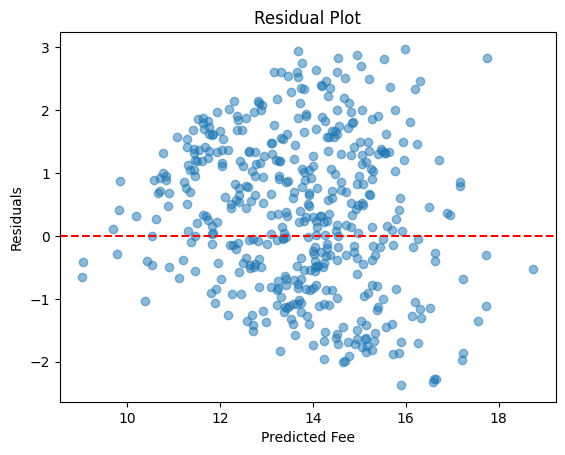

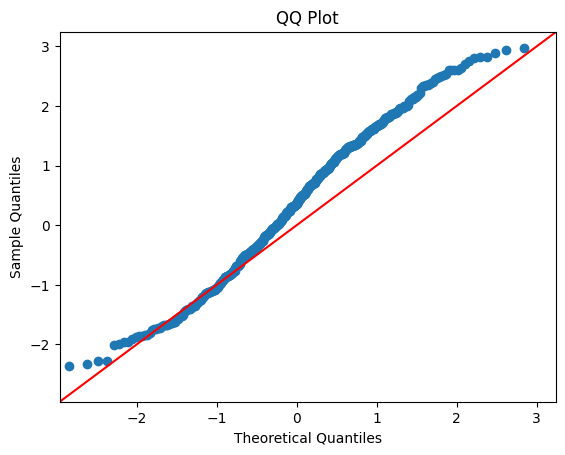

In [ ]:
removed_resid = np.delete(residuals, outliers_index)
removed_pred = np.delete(predicted_fee, outliers_index)


# Residual plot without outliers
plt.scatter(removed_pred, removed_resid, alpha=0.5)
plt.title('Residual Plot')
plt.xlabel('Predicted Fee')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# QQ Plot without outliers
sm.qqplot(removed_resid, line='45')
plt.title('QQ Plot')
plt.show()

In [ ]:
# remove outliers from the original outlier_df
new_df = outlier_df.drop(outlier_df.index[outliers_index])

# re-fit the model
X_new = new_df[['branches', 'weekday_weekend', 'time_of_day', 'distance_to_customer_KM']]
y_new = new_df['delivery_fee']

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.2, random_state=42)
model_new = LinearRegression()
model_new.fit(X_train_new, y_train_new)
predicted_fee_new = model_new.predict(X_test_new)

# re-cal mse
mse_new = mean_squared_error(y_test_new, predicted_fee_new)
print("Mean Squared Error with new model:", mse_new)


Mean Squared Error with new model: 1.3289854987475305


In [ ]:
outlier_df.shape, new_df.shape

((500, 15), (451, 15))

A total of 49 detected outliers were removed from the original dataframe, and the linear model was trained using the updated dataframe.The new Mean Squared Error (MSE) obtained is much lower than before, indicating the strong influence of outliers in the original dataframe.

In [ ]:
# save to file
new_df.to_csv("015_outlier_data_solution.csv", index=False)

<div class="alert alert-block alert-warning">

# 2. Task 2  <a class="Task2" name="Task2"></a>
    
</div>

The object of this task is to prepare the data for linear model usage by transforming or scaling. This dataset is about the suburb information with house number, house price, population, and other related demographic data inculded in. There are 8 columns and 202 rows in the data.

The goal is to: a) enhance the relationship between the features and the target variable (Median house price), which is done by transforamtion; b) keeping the same range across all feature , which is done by scaling. To ensure the range is the same, we decided to transform first, then scaling the features into the same range.

We firstly convert all the columns except 'suburb' and 'municipality' into numerical types for further data exploration usage.
Different transformation and scaling approaches are trying across various columns, including:
* Transformation:
  * Log
  * Power
  * Square Root
  * Inverse
  * Inverse Square Root
  * Inverse Square
* Scaling:
  * Min Max
  * Normalisation

Detailed implementation processes are shown in the following sections.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

suburb = pd.read_excel("/content/drive/Shareddrives/FIT5196_S1_2024/A2/supplementary_data/suburb_info.xlsx")
suburb.head(10)

,suburb,number_of_houses,number_of_units,municipality,aus_born_perc,median_income,median_house_price,population
0,ABBOTSFORD,2304,4706,Yarra,68%,"$1,797","$1,299,400",4025
1,ABERFELDIE,1410,453,Moonee Valley,81%,"$1,571","$1,926,600",22442
2,ALBANVALE,1897,138,Brimbank,46%,$907,"$594,200",54005
3,ALBION,1389,1392,Brimbank,52%,$929,"$739,100",30677
4,ALPHINGTON,1729,1099,Darebin,73%,"$1,538","$1,729,600",9227
5,ALTONA,4843,2394,Hobsons Bay,70%,"$1,160","$1,139,500",11742
6,ALTONA NORTH,5002,1622,Hobsons Bay,52%,$910,"$935,500",12830
7,ARDEER,1263,335,Brimbank,46%,$895,"$663,400",10176
8,ARMADALE,2838,3841,Stonnington,73%,"$1,713","$1,925,900",8428
9,ASHWOOD,2378,1176,Monash,73%,"$1,469","$1,436,500",12420


In [ ]:
# remove special char
suburb['aus_born_perc'] = suburb['aus_born_perc'].apply(lambda x: x.replace('%', ''))
suburb['median_income'] = suburb['median_income'].apply(lambda x: (x.replace((','), '').replace('$', '')))
suburb['median_house_price'] = suburb['median_house_price'].apply(lambda x: (x.replace((','), '').replace('$', '')))

# convert columns into numerical type
suburb['aus_born_perc'] = pd.to_numeric(suburb['aus_born_perc'])
# suburb['aus_born_perc'] = suburb['aus_born_perc'].apply(lambda x: x/100)

suburb['median_income'] = pd.to_numeric(suburb['median_income'])
suburb['median_house_price'] = pd.to_numeric(suburb['median_house_price'])

# check data
print(suburb.info())
suburb.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202 entries, 0 to 201
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   suburb              202 non-null    object
 1   number_of_houses    202 non-null    int64 
 2   number_of_units     202 non-null    int64 
 3   municipality        202 non-null    object
 4   aus_born_perc       202 non-null    int64 
 5   median_income       202 non-null    int64 
 6   median_house_price  202 non-null    int64 
 7   population          202 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 12.8+ KB
None


,suburb,number_of_houses,number_of_units,municipality,aus_born_perc,median_income,median_house_price,population
0,ABBOTSFORD,2304,4706,Yarra,68,1797,1299400,4025
1,ABERFELDIE,1410,453,Moonee Valley,81,1571,1926600,22442
2,ALBANVALE,1897,138,Brimbank,46,907,594200,54005
3,ALBION,1389,1392,Brimbank,52,929,739100,30677
4,ALPHINGTON,1729,1099,Darebin,73,1538,1729600,9227


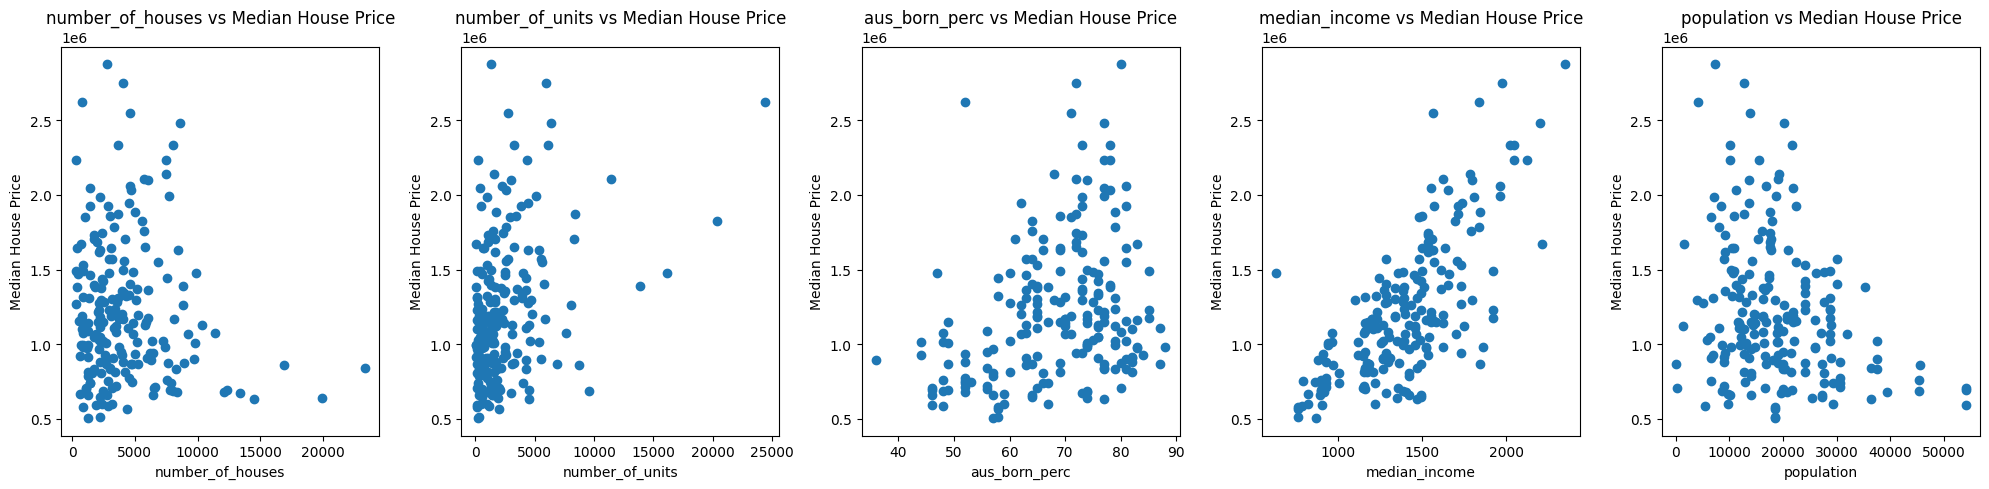

In [ ]:
# Define the variables
variables = ['number_of_houses', 'number_of_units', 'aus_born_perc', 'median_income', 'population']

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))

for i, var in enumerate(variables):
    ax = axes[i]
    ax.scatter(suburb[var], suburb['median_house_price'])
    ax.set_xlabel(var)
    ax.set_ylabel('Median House Price')
    ax.set_title(f'{var} vs Median House Price')

plt.tight_layout()
plt.show()

In [ ]:
correlations = suburb[variables + ['median_house_price']].corr()
target_corr = correlations['median_house_price'].drop('median_house_price')

print("Pearson Correlation Coefficients with Target Variable:\n")
print(target_corr)

Pearson Correlation Coefficients with Target Variable:

number_of_houses   -0.104490
number_of_units     0.343858
aus_born_perc       0.303860
median_income       0.719384
population         -0.287242
Name: median_house_price, dtype: float64


In [ ]:
def find_r2(features, target, data):
    """
    Trains a linear regression model using defined features and target,
    evaluates the model, generate scatter plot and returns the R2 score.

    :param features: List of feature column names
    :param target: Target column name
    :param data: DataFrame containing the features and target
    :return: R2 score
    """
    # Prepare the data
    X_train = data[features]
    y_train = data[target]

    # Train the linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict the target values
    y_pred = model.predict(X_train)

    # Evaluate the model
    r2 = r2_score(y_train, y_pred)
    return r2

In [ ]:
def find_corr(features, target):
    """
    Calculates Pearson correlation coefficients between features and the target variable.
    :param features: List of feature column names
    :param target: Target column name
    :param data: DataFrame containing the features and target
    :return: Series of correlation coefficients
    """
    # Calculate correlations
    correlations = round(suburb[features + [target]].corr(),4)
    target_corr = correlations[target].drop(target)
    return target_corr

## Same transformation across all columns

In this part, we will set the same transformation across all variables to discover if any valuable linear relationship is existing between target and features. There are three transformation approaches are applying to the dataset, including `power`, `log`, and `square root` transformation.

### Power transformation

After transforming all columns with a `power of 0.6`, we observed that the correlation remains quite similar as the original data. There is a slight increase in the correlation values for `number of units` and `aus born perc` compared to the original dataset, indicating a positive moderate correlation. However, the correlation for `median income`, which originally had a strong positive correlation, decreased slightly. At the same time, there was a decrease in the population.

In [ ]:
features = ['power_number_of_houses', 'power_number_of_units', 'power_aus_born_perc', 'power_median_income', 'power_population']

correlations = suburb[features + ['power_median_house_price']].corr()
target_corr = correlations['power_median_house_price'].drop('power_median_house_price')

print("Pearson Correlation Coefficients with Target Variable:\n")
print(target_corr)

Pearson Correlation Coefficients with Target Variable:

power_number_of_houses   -0.092046
power_number_of_units     0.351707
power_aus_born_perc       0.327972
power_median_income       0.714190
power_population         -0.264538
Name: power_median_house_price, dtype: float64


In [ ]:
# power transformation
power = 0.6

suburb['power_number_of_houses'] = suburb['number_of_houses'].apply(lambda x: np.power(x, power))
suburb['power_number_of_units'] = suburb['number_of_units'].apply(lambda x: np.power(x, power))
suburb['power_aus_born_perc'] = suburb['aus_born_perc'].apply(lambda x: np.power(x, power))
suburb['power_median_income'] = suburb['median_income'].apply(lambda x: np.power(x, power))
suburb['power_median_house_price'] = suburb['median_house_price'].apply(lambda x: np.power(x, power))
suburb['power_population'] = suburb['population'].apply(lambda x: np.power(x, power))

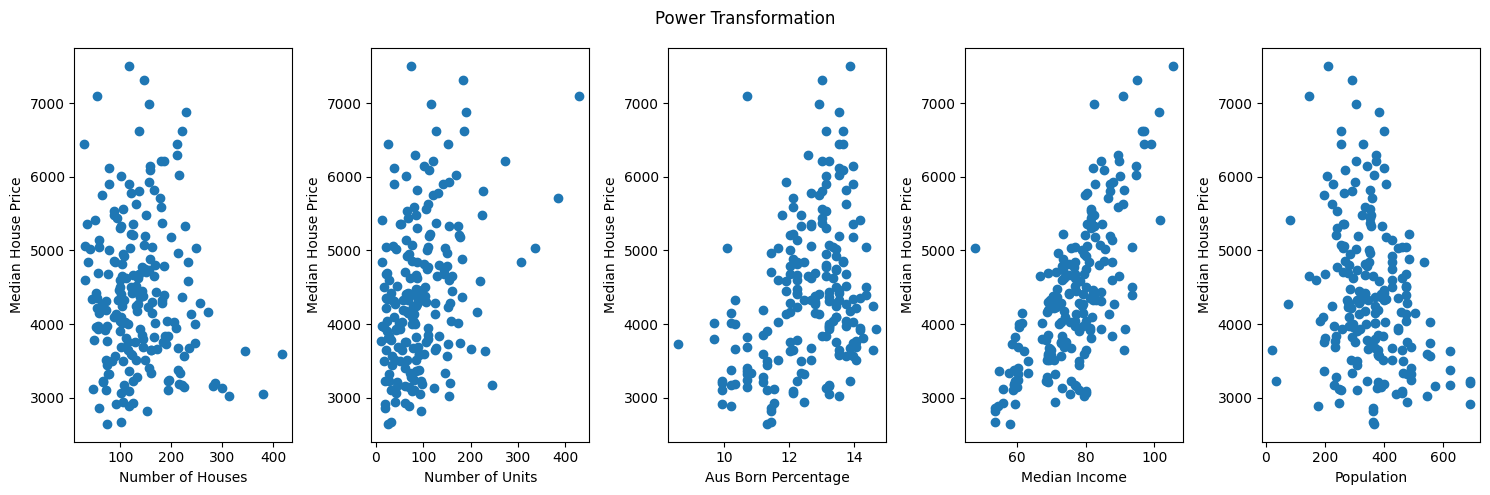

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(15, 5))

# check imputed data with original data
axs[0].scatter(suburb['power_number_of_houses'], suburb['power_median_house_price'])
axs[0].set_xlabel('Number of Houses')
axs[0].set_ylabel('Median House Price')

axs[1].scatter(suburb['power_number_of_units'], suburb['power_median_house_price'])
axs[1].set_xlabel('Number of Units')
axs[1].set_ylabel('Median House Price')

axs[2].scatter(suburb['power_aus_born_perc'], suburb['power_median_house_price'])
axs[2].set_xlabel('Aus Born Percentage')
axs[2].set_ylabel('Median House Price')

axs[3].scatter(suburb['power_median_income'], suburb['power_median_house_price'])
axs[3].set_xlabel('Median Income')
axs[3].set_ylabel('Median House Price')

axs[4].scatter(suburb['power_population'], suburb['power_median_house_price'])
axs[4].set_xlabel('Population')
axs[4].set_ylabel('Median House Price')

plt.suptitle("Power Transformation")
plt.tight_layout()
plt.show()

### Log transformation

After applying a `log` transformation, we observed a decrease in the correlation for most columns, except for `aus_born_perc`. Interestingly, the log transformation of `aus_born_perc` generate a higher correlation score compared to the power transformation.

In [ ]:
# log transformation
suburb['log_number_of_houses'] = suburb['number_of_houses'].apply(lambda x: np.log2(x))
suburb['log_number_of_units'] = suburb['number_of_units'].apply(lambda x: np.log2(x))
suburb['log_aus_born_perc'] = suburb['aus_born_perc'].apply(lambda x: np.log2(x))
suburb['log_median_income'] = suburb['median_income'].apply(lambda x: np.log2(x))
suburb['log_median_house_price'] = suburb['median_house_price'].apply(lambda x: np.log2(x))
suburb['log_population'] = suburb['population'].apply(lambda x: np.log2(x))

In [ ]:
features = ['log_number_of_houses', 'log_number_of_units', 'log_aus_born_perc', 'log_median_income', 'log_population']

correlations = suburb[features + ['log_median_house_price']].corr()
target_corr = correlations['log_median_house_price'].drop('log_median_house_price')

print("Pearson Correlation Coefficients with Target Variable:\n")
print(target_corr)

Pearson Correlation Coefficients with Target Variable:

log_number_of_houses   -0.078780
log_number_of_units     0.309686
log_aus_born_perc       0.359236
log_median_income       0.703318
log_population         -0.153122
Name: log_median_house_price, dtype: float64


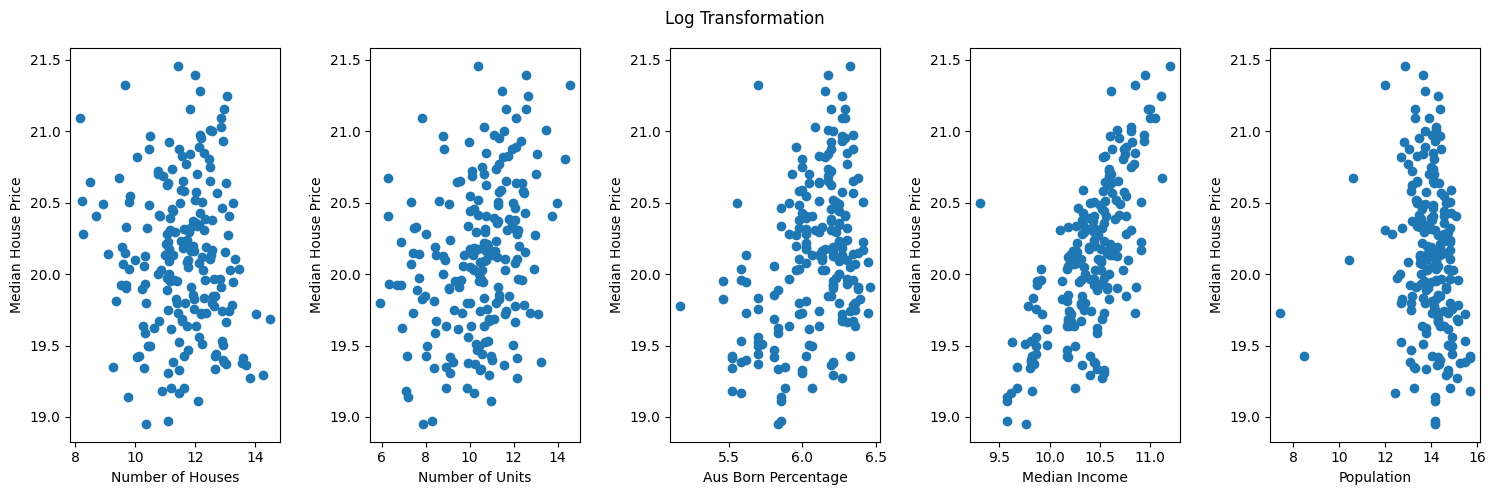

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(15, 5))

# check imputed data with original data
axs[0].scatter(suburb['log_number_of_houses'], suburb['log_median_house_price'])
axs[0].set_xlabel('Number of Houses')
axs[0].set_ylabel('Median House Price')

axs[1].scatter(suburb['log_number_of_units'], suburb['log_median_house_price'])
axs[1].set_xlabel('Number of Units')
axs[1].set_ylabel('Median House Price')

axs[2].scatter(suburb['log_aus_born_perc'], suburb['log_median_house_price'])
axs[2].set_xlabel('Aus Born Percentage')
axs[2].set_ylabel('Median House Price')

axs[3].scatter(suburb['log_median_income'], suburb['log_median_house_price'])
axs[3].set_xlabel('Median Income')
axs[3].set_ylabel('Median House Price')

axs[4].scatter(suburb['log_population'], suburb['log_median_house_price'])
axs[4].set_xlabel('Population')
axs[4].set_ylabel('Median House Price')

plt.suptitle("Log Transformation")
plt.tight_layout()
plt.show()

### Suqare root transformation

After applying the `square root (sqrt)` transformation, we found that the correlation scores fell between those obtained from `power` and `log` transformations. Therefore, if we were to choose a transformation approach for all columns, sqrt might not be the preferred choice.

In [ ]:
# square root
suburb['sqrt_number_of_houses'] = np.sqrt(suburb['number_of_houses'])
suburb['sqrt_number_of_units'] = np.sqrt(suburb[['number_of_units']])
suburb['sqrt_aus_born_perc'] = np.sqrt(suburb[['aus_born_perc']])
suburb['sqrt_median_income'] = np.sqrt(suburb[['median_income']])
suburb['sqrt_median_house_price'] = np.sqrt(suburb[['median_house_price']])
suburb['sqrt_population'] = np.sqrt(suburb[['population']])


In [ ]:
features = ['sqrt_number_of_houses', 'sqrt_number_of_units', 'sqrt_aus_born_perc', 'sqrt_median_income', 'sqrt_population']

correlations = suburb[features + ['sqrt_median_house_price']].corr()
target_corr = correlations['sqrt_median_house_price'].drop('sqrt_median_house_price')

print("Pearson Correlation Coefficients with Target Variable:\n")
print(target_corr)

Pearson Correlation Coefficients with Target Variable:

sqrt_number_of_houses   -0.088913
sqrt_number_of_units     0.349885
sqrt_aus_born_perc       0.333674
sqrt_median_income       0.712628
sqrt_population         -0.253785
Name: sqrt_median_house_price, dtype: float64


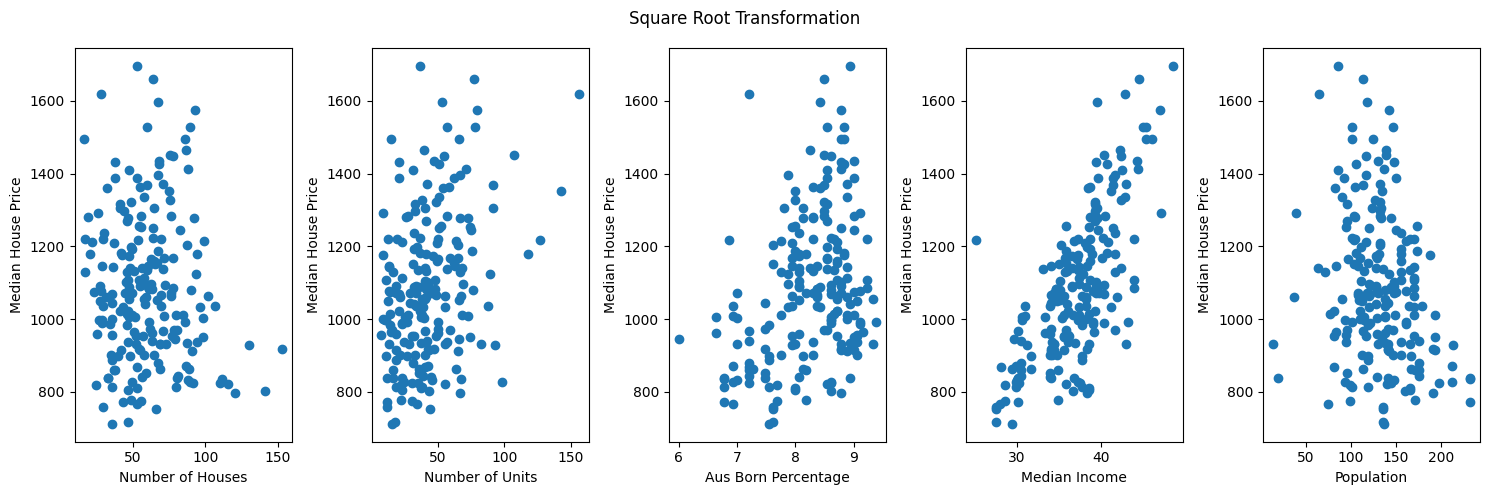

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(15, 5))

# check imputed data with original data
axs[0].scatter(suburb['sqrt_number_of_houses'], suburb['sqrt_median_house_price'])
axs[0].set_xlabel('Number of Houses')
axs[0].set_ylabel('Median House Price')

axs[1].scatter(suburb['sqrt_number_of_units'], suburb['sqrt_median_house_price'])
axs[1].set_xlabel('Number of Units')
axs[1].set_ylabel('Median House Price')

axs[2].scatter(suburb['sqrt_aus_born_perc'], suburb['sqrt_median_house_price'])
axs[2].set_xlabel('Aus Born Percentage')
axs[2].set_ylabel('Median House Price')

axs[3].scatter(suburb['sqrt_median_income'], suburb['sqrt_median_house_price'])
axs[3].set_xlabel('Median Income')
axs[3].set_ylabel('Median House Price')

axs[4].scatter(suburb['sqrt_population'], suburb['sqrt_median_house_price'])
axs[4].set_xlabel('Population')
axs[4].set_ylabel('Median House Price')

plt.suptitle("Square Root Transformation")
plt.tight_layout()
plt.show()

### Inverse transformation

Similar to the log transformation, we observed a slight drop in most correlations after implementing the `inverse` transformation, except for `aus born perc`. The inverse transformation shows a higher correlation with `aus born perc` compared to the log transformation. Further exploration can be found in transformation by column part.

In [ ]:
# inverse
suburb['inv_number_of_houses'] = -1/suburb['number_of_houses']
suburb['inv_number_of_units'] = -1/suburb['number_of_units']
suburb['inv_aus_born_perc'] = -1/suburb['aus_born_perc']
suburb['inv_median_income'] = -1/suburb['median_income']
suburb['inv_median_house_price'] = -1/suburb['median_house_price']
suburb['inv_population'] = -1/suburb['population']

In [ ]:
features = ['inv_number_of_houses', 'inv_number_of_units', 'inv_aus_born_perc', 'inv_median_income', 'inv_population']

correlations = suburb[features + ['inv_median_house_price']].corr()
target_corr = correlations['inv_median_house_price'].drop('inv_median_house_price')

print("Pearson Correlation Coefficients with Target Variable:\n")
print(target_corr)

Pearson Correlation Coefficients with Target Variable:

inv_number_of_houses   -0.098798
inv_number_of_units     0.150481
inv_aus_born_perc       0.388968
inv_median_income       0.678300
inv_population          0.059453
Name: inv_median_house_price, dtype: float64


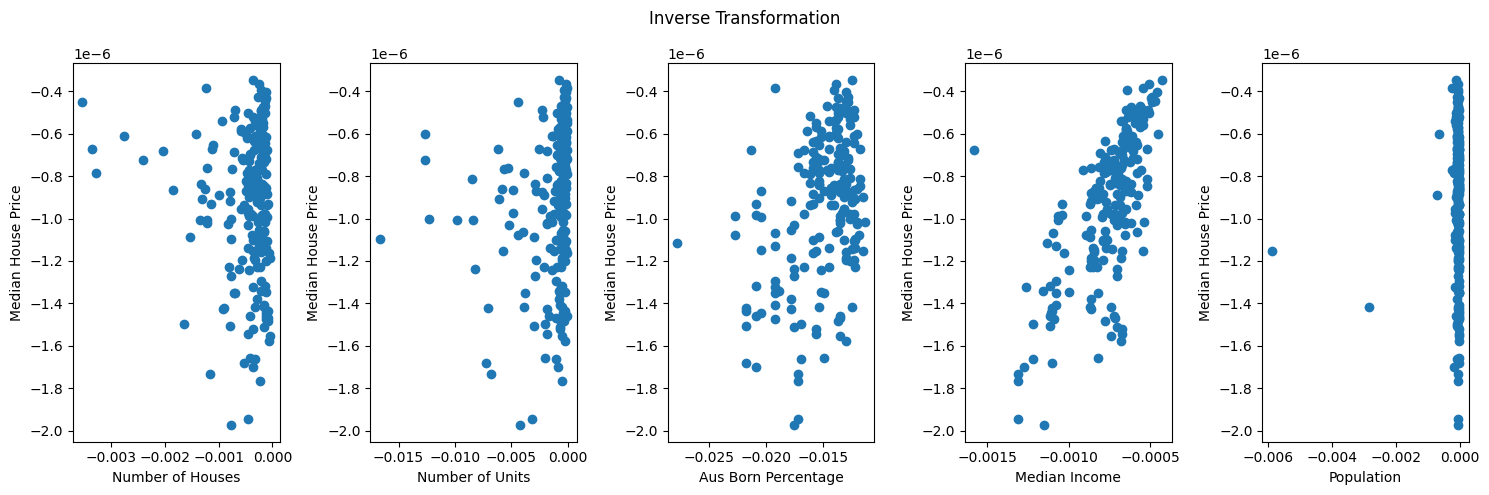

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(15, 5))

# check imputed data with original data
axs[0].scatter(suburb['inv_number_of_houses'], suburb['inv_median_house_price'])
axs[0].set_xlabel('Number of Houses')
axs[0].set_ylabel('Median House Price')

axs[1].scatter(suburb['inv_number_of_units'], suburb['inv_median_house_price'])
axs[1].set_xlabel('Number of Units')
axs[1].set_ylabel('Median House Price')

axs[2].scatter(suburb['inv_aus_born_perc'], suburb['inv_median_house_price'])
axs[2].set_xlabel('Aus Born Percentage')
axs[2].set_ylabel('Median House Price')

axs[3].scatter(suburb['inv_median_income'], suburb['inv_median_house_price'])
axs[3].set_xlabel('Median Income')
axs[3].set_ylabel('Median House Price')

axs[4].scatter(suburb['inv_population'], suburb['inv_median_house_price'])
axs[4].set_xlabel('Population')
axs[4].set_ylabel('Median House Price')

plt.suptitle("Inverse Transformation")
plt.tight_layout()
plt.show()

## Transformation by column

In the previous part, applying the same transformation across all columns did not yield satisfactory results. Therefore, in this part, each column was transformed independently based on the characteristics of its distribution and scatter plot.

### median_house_price

In the first step, the target variable, `median_house_price` was transformed as it increases significantly with respect to the features.

Both log and power (square root) transformations were tested. The resulting correlations were very similar, with most features showing a stronger relationship, except for `number_of_units` and `aus_born_perc`. The R-squared value applying the power transformation was slightly higher. However, considering the density plot generated using the log transformation was more normal and that there were minimal difference between the two methods, the log transformation was chosen to preserve some ideal characteristics of the dataset. This transformation reduced the disparity in the target variable.

In [ ]:
suburb['new_median_house_price_log'] = np.log(suburb['median_house_price'])
suburb['new_median_house_price_sqrt'] = np.power(suburb['median_house_price'], 0.5)

In [ ]:
variables = ['number_of_houses', 'number_of_units', 'aus_born_perc', 'median_income', 'population']

target = 'median_house_price'
corr_y = find_corr(variables, target)
print('Corr of y: ','\n', corr_y,'\n')

target = 'new_median_house_price_log'
corr_ylog = find_corr(variables, target)
print('Corr of log y: ','\n', corr_ylog,'\n')

target = 'new_median_house_price_sqrt'
corr_ysqrt = find_corr(variables, target)
print('Corr of sqrt y: ','\n', corr_ysqrt,'\n')

Corr of y:  
 number_of_houses   -0.1045
number_of_units     0.3439
aus_born_perc       0.3039
median_income       0.7194
population         -0.2872
Name: median_house_price, dtype: float64 

Corr of log y:  
 number_of_houses   -0.1310
number_of_units     0.3193
aus_born_perc       0.3472
median_income       0.7198
population         -0.2985
Name: new_median_house_price_log, dtype: float64 

Corr of sqrt y:  
 number_of_houses   -0.1191
number_of_units     0.3334
aus_born_perc       0.3269
median_income       0.7235
population         -0.2947
Name: new_median_house_price_sqrt, dtype: float64 



In [ ]:
# Analyze with log transformation
print("Log Transformation Analysis:")
r2_log = find_r2(variables, 'new_median_house_price_log', suburb)
print(f"R-squared for log transformation: {r2_log}")

# Analyze with power transformation
print("\nPower Transformation Analysis:")
r2_power = find_r2(variables, 'new_median_house_price_sqrt', suburb)
print(f"R-squared for power transformation: {r2_power}")

Log Transformation Analysis:
R-squared for log transformation: 0.6267518791040558

Power Transformation Analysis:
R-squared for power transformation: 0.6378013952948218


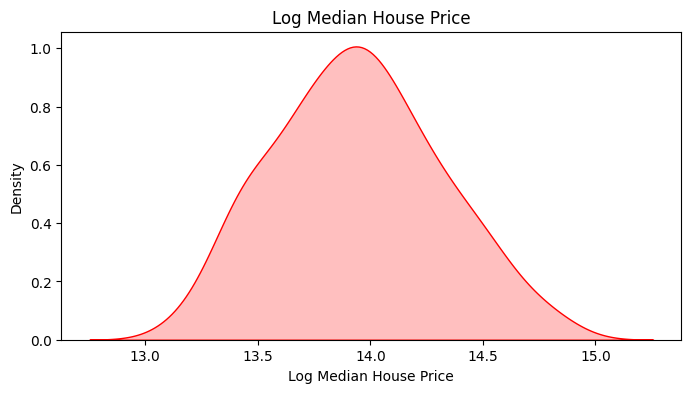

In [ ]:
plt.figure(figsize=(8, 4))
sns.kdeplot(suburb['new_median_house_price_log'], color='red', fill=True)
plt.xlabel('Log Median House Price')
plt.ylabel('Density')
plt.title('Log Median House Price')
plt.show()

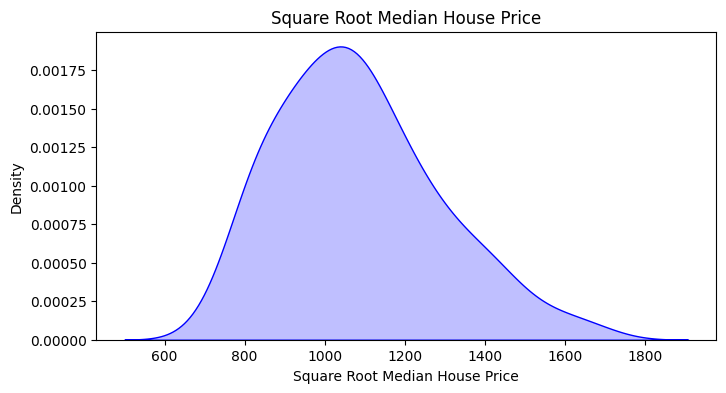

In [ ]:
plt.figure(figsize=(8, 4))
sns.kdeplot(suburb['new_median_house_price_sqrt'], color='blue', fill=True)
plt.xlabel('Square Root Median House Price')
plt.ylabel('Density')
plt.title('Square Root Median House Price')
plt.show()


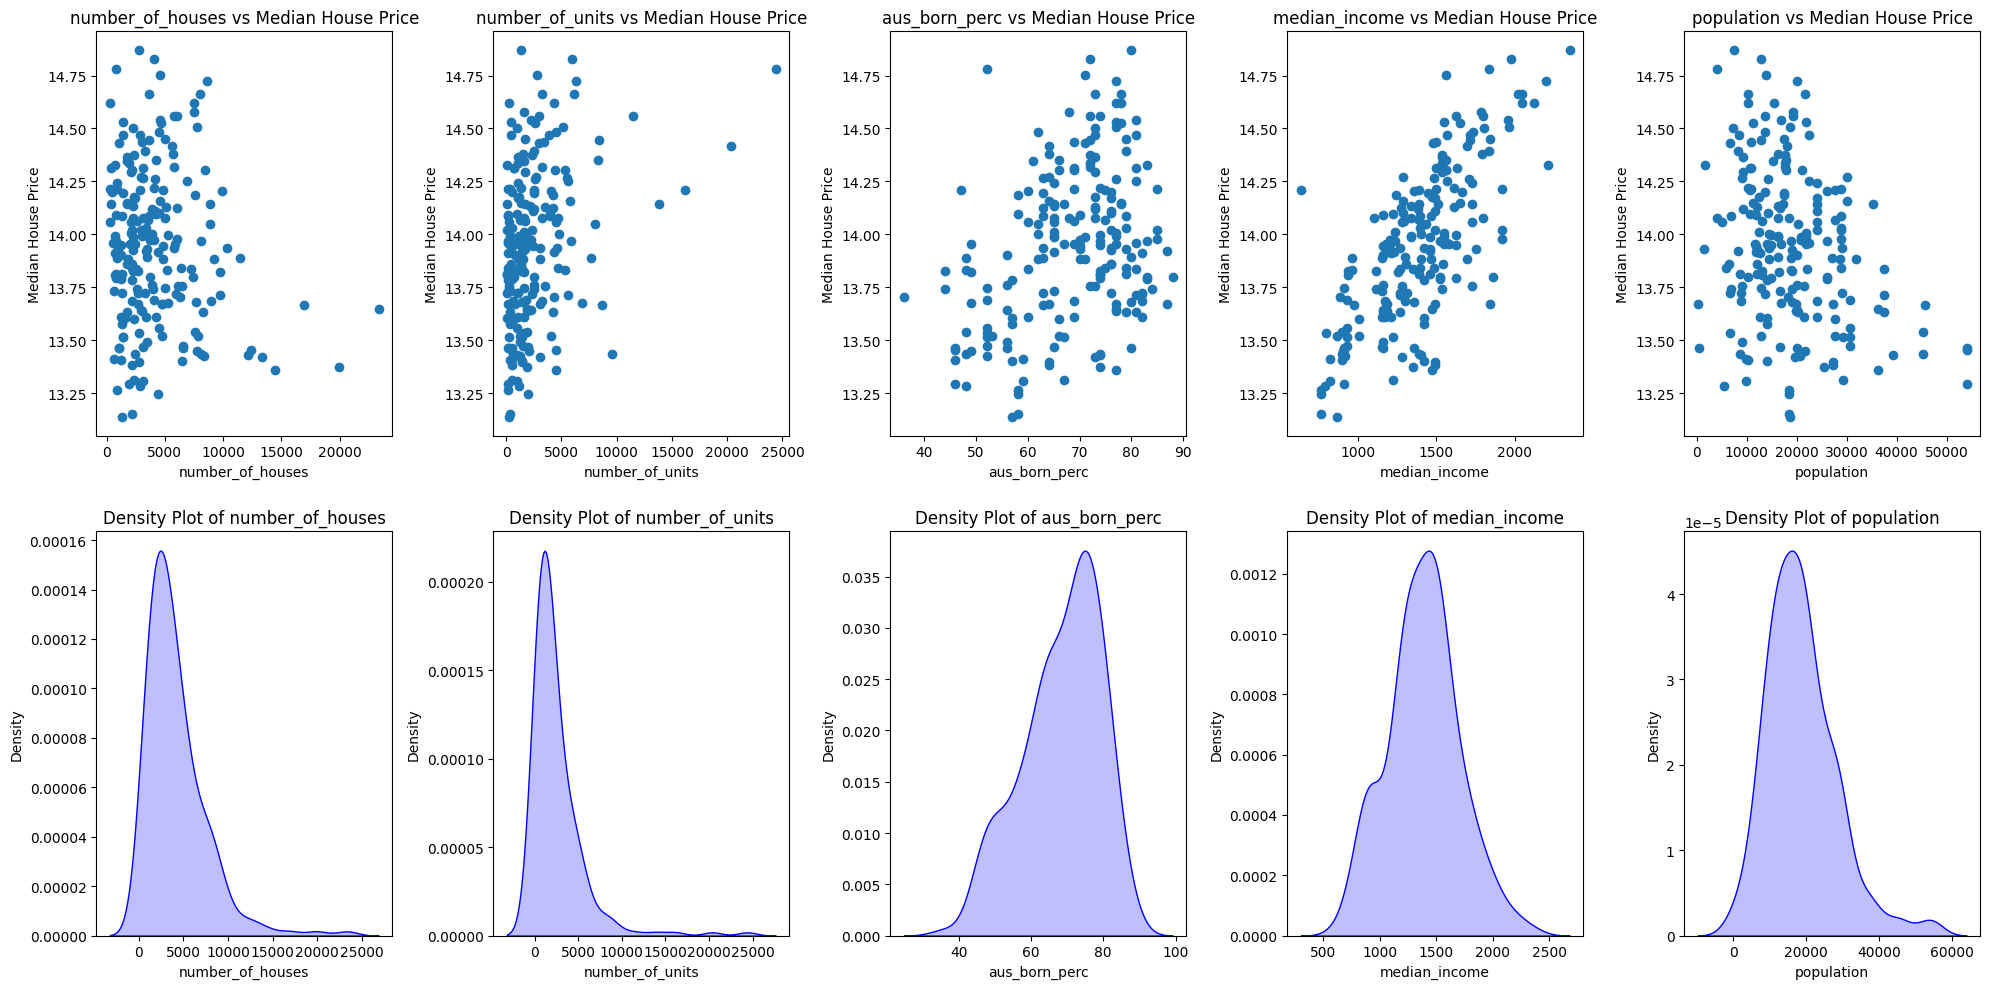

In [ ]:
import seaborn as sns

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))

# Scatter plots
for i, var in enumerate(variables):
    ax = axes[0, i]
    ax.scatter(suburb[var], suburb['new_median_house_price_log'])
    ax.set_xlabel(var)
    ax.set_ylabel('Median House Price')
    ax.set_title(f'{var} vs Median House Price')

# Density plots
for i, var in enumerate(variables):
    ax = axes[1, i]
    sns.kdeplot(suburb[var], ax=ax, color='blue', fill=True)
    ax.set_xlabel(var)
    ax.set_ylabel('Density')
    ax.set_title(f'Density Plot of {var}')

plt.tight_layout()
plt.show()


### population

Next, `population`  was transformed. It was observed that the values in `population` exhibited slight non-linearity with the target variable.

Initially, attempts were made to transform the values downward, but it was found that the non-linearity got worse in this transformation, resulting in decreased correlation. Therefore, it was transformed upwards by applying either a log or power transformation with a power greater than 1.

The correlation between the target and `population` variables was maximized when applying the square transformation. The non-linearity issues became less obvious after this transformation was applied.

In [ ]:
suburb['new_population_log'] = np.log(suburb['population'])
suburb['new_population_sq'] = np.power(suburb['population'], 2)
suburb['new_population_cu'] = np.power(suburb['population'], 3)


features_log = ['number_of_houses', 'number_of_units', 'aus_born_perc', 'median_income', 'new_population_log']
features_sq= ['number_of_houses', 'number_of_units', 'aus_born_perc', 'median_income', 'new_population_sq']
features_cu= ['number_of_houses', 'number_of_units', 'aus_born_perc', 'median_income', 'new_population_cu']


In [ ]:
target = 'new_median_house_price_log'
corr = find_corr(features_log, target)
print('Corr of log population: ','\n', corr,'\n')

corr = find_corr(features_sq, target)
print('Corr of pop^2: ','\n', corr,'\n')

corr = find_corr(features_cu, target)
print('Corr of pop^3: ','\n', corr,'\n')


Corr of log population:  
 number_of_houses     -0.1310
number_of_units       0.3193
aus_born_perc         0.3472
median_income         0.7198
new_population_log   -0.1531
Name: new_median_house_price_log, dtype: float64 

Corr of pop^2:  
 number_of_houses    -0.1310
number_of_units      0.3193
aus_born_perc        0.3472
median_income        0.7198
new_population_sq   -0.3217
Name: new_median_house_price_log, dtype: float64 

Corr of pop^3:  
 number_of_houses    -0.1310
number_of_units      0.3193
aus_born_perc        0.3472
median_income        0.7198
new_population_cu   -0.3085
Name: new_median_house_price_log, dtype: float64 



In [ ]:
r2_log = find_r2(features_log, 'new_median_house_price_log', suburb)
print(f"R-squared: {r2_log}")

r2_power = find_r2(features_sq, 'new_median_house_price_log', suburb)
print(f"R-squared: {r2_power}")

r2_power = find_r2(features_cu, 'new_median_house_price_log', suburb)
print(f"R-squared: {r2_power}")

R-squared: 0.6290096514561223
R-squared: 0.6310389693844964
R-squared: 0.6307082055703341


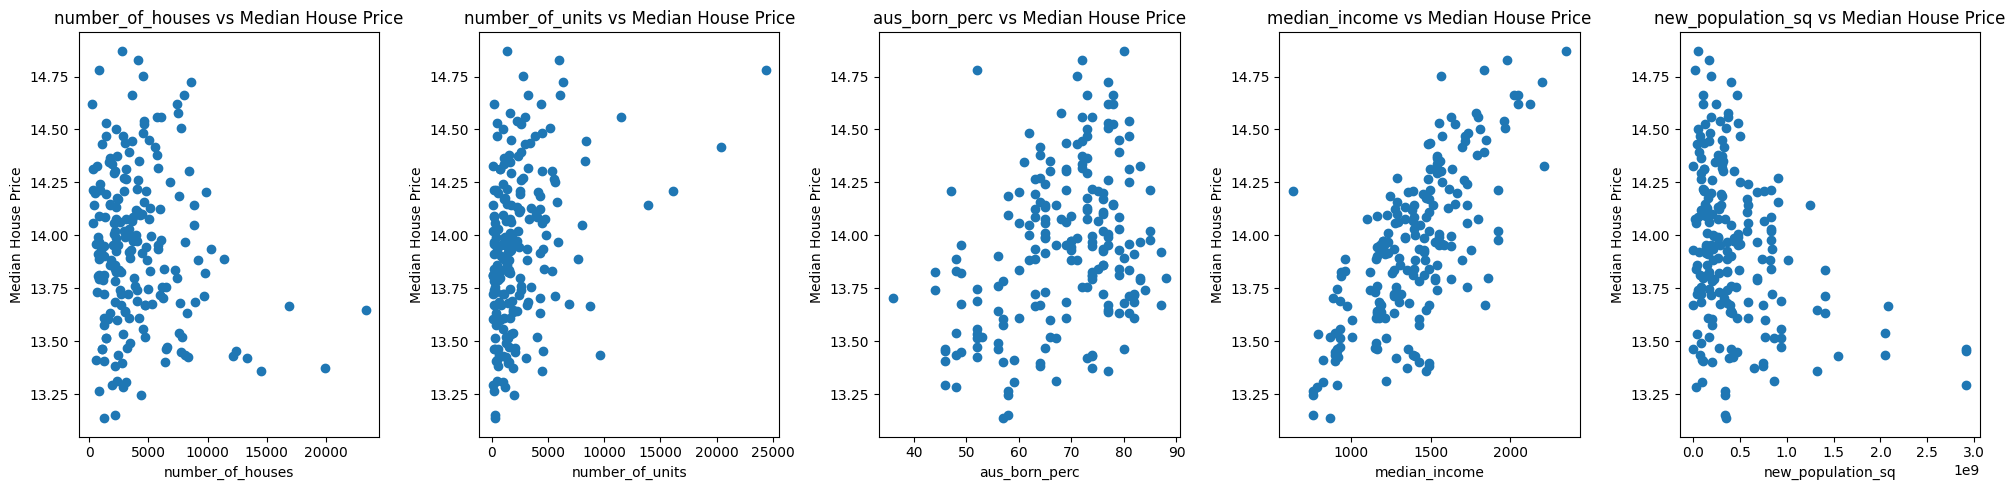

In [ ]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))

for i, var in enumerate(features_sq):
    ax = axes[i]
    ax.scatter(suburb[var], suburb['new_median_house_price_log'])
    ax.set_xlabel(var)
    ax.set_ylabel('Median House Price')
    ax.set_title(f'{var} vs Median House Price')

plt.tight_layout()
plt.show()

### number_of_houses

Next, `number_of_houses`  was transformed. Observing that there were a few datapoints far apart on the right from the main cluster, the initial thought was to transform the value down to eliminate the difference. However the relationship afterwards was weaken. Therefore `number_of_houses` was transformed upwards instead and it is found that the squaring the term would generate the strongest relationship.

This would create a stronger difference betweedn the main cluster and the datapoints on the right, which potentially created outlier. In fact, removing those datapoints could result in an even stronger relationship.

In [ ]:
suburb['new_number_of_houses_log'] = np.log(suburb['number_of_houses'])
suburb['new_number_of_houses_sq'] = suburb['number_of_houses']**2
suburb['new_number_of_houses_cu'] = suburb['number_of_houses']**3
suburb['new_number_of_houses_fo'] = suburb['number_of_houses']**4


features_log = ['new_number_of_houses_log', 'number_of_units', 'aus_born_perc', 'median_income', 'new_population_sq']
features_sq = ['new_number_of_houses_sq', 'number_of_units', 'aus_born_perc', 'median_income', 'new_population_sq']

features_cu = ['new_number_of_houses_cu', 'number_of_units', 'aus_born_perc', 'median_income', 'new_population_sq']
features_fo = ['new_number_of_houses_fo', 'number_of_units', 'aus_born_perc', 'median_income', 'new_population_sq']


In [ ]:
target = 'new_median_house_price_log'
corr = find_corr(features_log, target)
print('Corr: ','\n', corr,'\n')

corr = find_corr(features_sq, target)
print('Corr: ','\n', corr,'\n')

corr = find_corr(features_cu, target)
print('Corr: ','\n', corr,'\n')

corr = find_corr(features_fo, target)
print('Corr: ','\n', corr,'\n')


Corr:  
 new_number_of_houses_log   -0.0788
number_of_units             0.3193
aus_born_perc               0.3472
median_income               0.7198
new_population_sq          -0.3217
Name: new_median_house_price_log, dtype: float64 

Corr:  
 new_number_of_houses_sq   -0.1697
number_of_units            0.3193
aus_born_perc              0.3472
median_income              0.7198
new_population_sq         -0.3217
Name: new_median_house_price_log, dtype: float64 

Corr:  
 new_number_of_houses_cu   -0.1638
number_of_units            0.3193
aus_born_perc              0.3472
median_income              0.7198
new_population_sq         -0.3217
Name: new_median_house_price_log, dtype: float64 

Corr:  
 new_number_of_houses_fo   -0.1442
number_of_units            0.3193
aus_born_perc              0.3472
median_income              0.7198
new_population_sq         -0.3217
Name: new_median_house_price_log, dtype: float64 



In [ ]:
r2_log = find_r2(features_log, 'new_median_house_price_log', suburb)
print(f"R-squared for log transformation: {r2_log}")

r2_power = find_r2(features_sq, 'new_median_house_price_log', suburb)
print(f"R-squared for square transformation: {r2_power}")

r2_power = find_r2(features_cu, 'new_median_house_price_log', suburb)
print(f"R-squared for cubic transformation: {r2_power}")

r2_power = find_r2(features_fo, 'new_median_house_price_log', suburb)
print(f"R-squared for power transformation: {r2_power}")

R-squared for log transformation: 0.6194657170783509
R-squared for square transformation: 0.6310686410641517
R-squared for cubic transformation: 0.6244400852222929
R-squared for power transformation: 0.6195373594466338


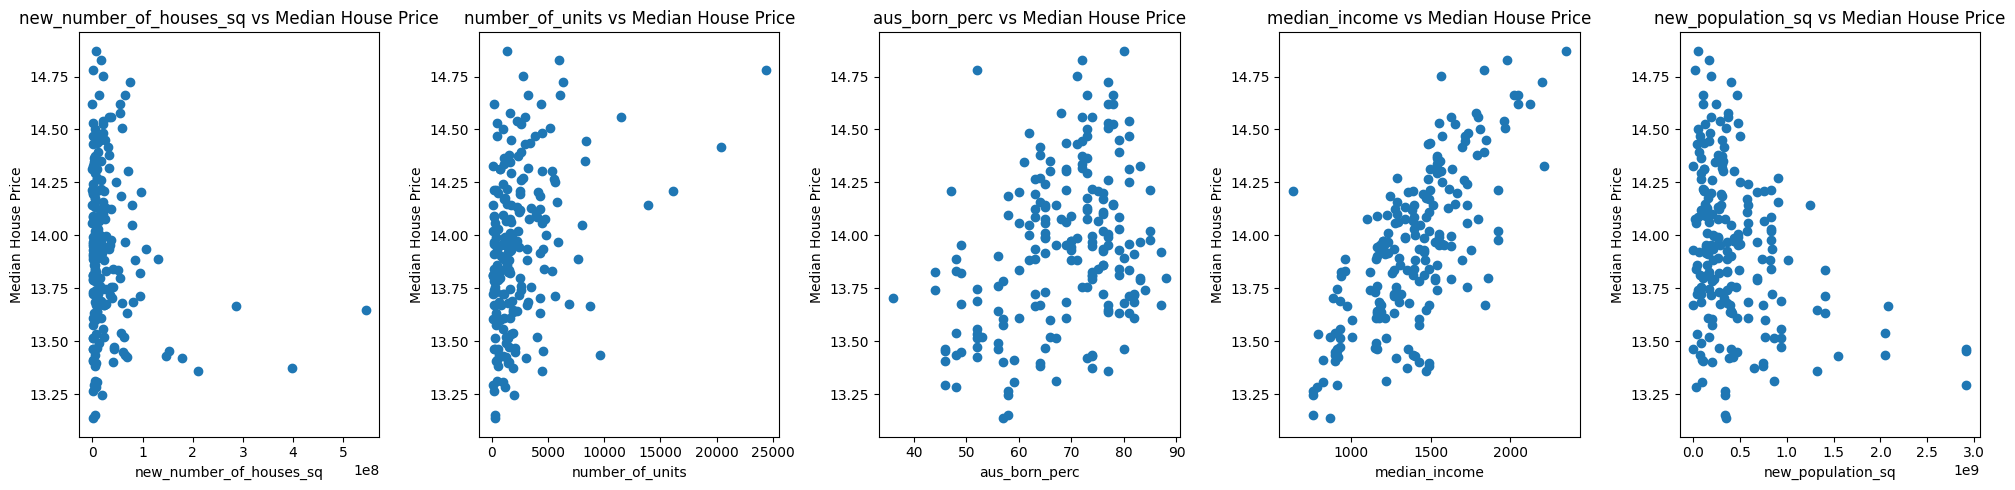

In [ ]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))

for i, var in enumerate(features_sq):
    ax = axes[i]
    ax.scatter(suburb[var], suburb['new_median_house_price_log'])
    ax.set_xlabel(var)
    ax.set_ylabel('Median House Price')
    ax.set_title(f'{var} vs Median House Price')

plt.tight_layout()
plt.show()

### number_of_units

From the scatter plot of the `number_of_units` variable, it was observed that some values were too large. Therefore the variable was transformed downward, and the square root transformation provided the best results.

In [ ]:
suburb['new_number_of_units_log'] = np.log(suburb['number_of_units'])
suburb['new_number_of_units_sqrt'] = np.sqrt(suburb['number_of_units'])
suburb['new_number_of_units_cbrt'] = np.cbrt(suburb['number_of_units'])

features_log = ['new_number_of_houses_sq', 'new_number_of_units_log', 'aus_born_perc', 'median_income', 'new_population_sq']
features_sqrt = ['new_number_of_houses_sq', 'new_number_of_units_sqrt', 'aus_born_perc', 'median_income', 'new_population_sq']
features_cbrt = ['new_number_of_houses_sq', 'new_number_of_units_cbrt', 'aus_born_perc', 'median_income', 'new_population_sq']

In [ ]:
target = 'new_median_house_price_log'
corr = find_corr(features_log, target)
print('Corr: ','\n', corr,'\n')

corr = find_corr(features_sqrt, target)
print('Corr: ','\n', corr,'\n')

corr = find_corr(features_cu, target)
print('Corr: ','\n', corr,'\n')

Corr:  
 new_number_of_houses_sq   -0.1697
new_number_of_units_log    0.3097
aus_born_perc              0.3472
median_income              0.7198
new_population_sq         -0.3217
Name: new_median_house_price_log, dtype: float64 

Corr:  
 new_number_of_houses_sq    -0.1697
new_number_of_units_sqrt    0.3405
aus_born_perc               0.3472
median_income               0.7198
new_population_sq          -0.3217
Name: new_median_house_price_log, dtype: float64 

Corr:  
 new_number_of_houses_cu   -0.1638
number_of_units            0.3193
aus_born_perc              0.3472
median_income              0.7198
new_population_sq         -0.3217
Name: new_median_house_price_log, dtype: float64 



In [ ]:
r2_log = find_r2(features_log, 'new_median_house_price_log', suburb)
print(f"R-squared for log transformation: {r2_log}")

r2_power = find_r2(features_sqrt, 'new_median_house_price_log', suburb)
print(f"R-squared for square root transformation: {r2_power}")

r2_power = find_r2(features_cbrt, 'new_median_house_price_log', suburb)
print(f"R-squared for cubic root transformation: {r2_power}")

R-squared for log transformation: 0.6568012657623514
R-squared for square root transformation: 0.6595421821903646
R-squared for cubic root transformation: 0.6634202521948582


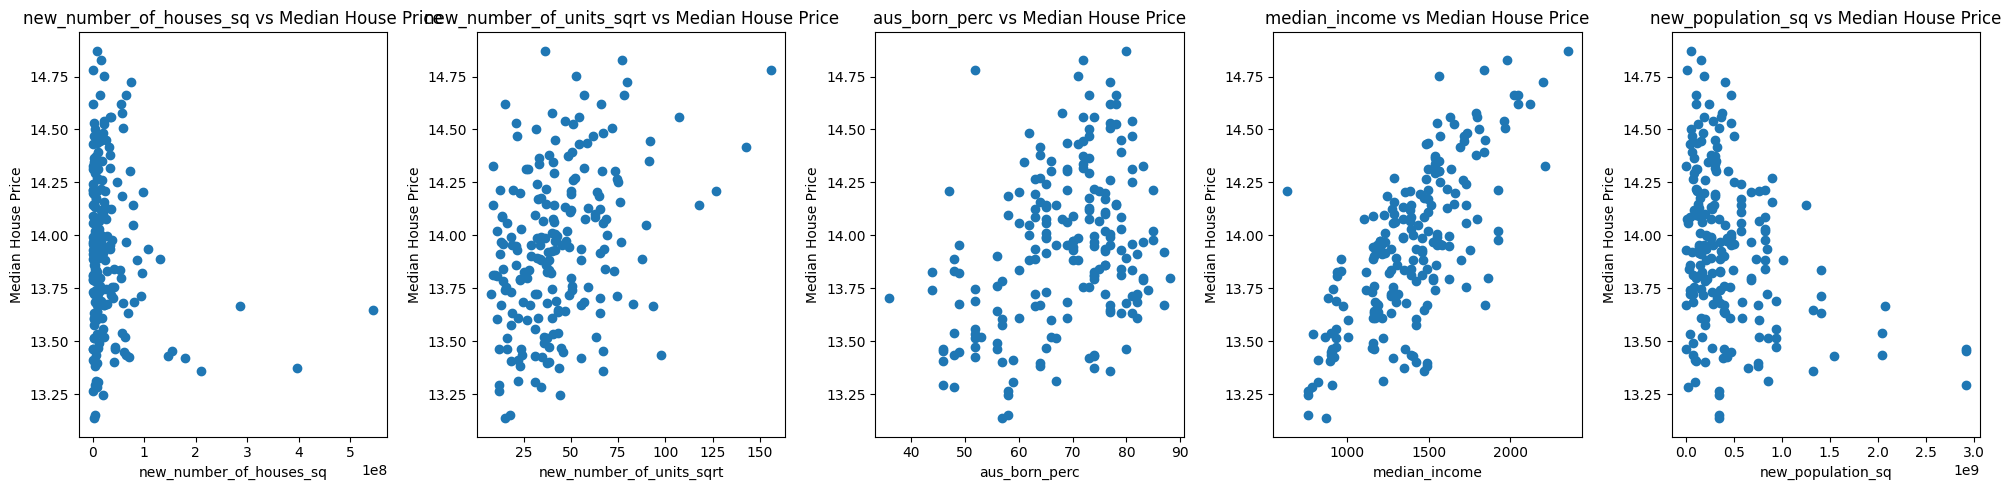

In [ ]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))

for i, var in enumerate(features_sqrt):
    ax = axes[i]
    ax.scatter(suburb[var], suburb['new_median_house_price_log'])
    ax.set_xlabel(var)
    ax.set_ylabel('Median House Price')
    ax.set_title(f'{var} vs Median House Price')

plt.tight_layout()
plt.show()

### aus_born_perc

For the `aus_born_perc` variable, it was not obvious to determine if the values needed to be scaled up or down. Therefore, both directions were tested. It was found that taking the inverse of the original values resulted in a stronger relationship with the target variable.

In [ ]:
suburb['new_aus_born_perc_log'] = np.log(suburb['aus_born_perc'])
suburb['new_aus_born_perc_sqrt'] = np.sqrt(suburb['aus_born_perc'])
suburb['new_aus_born_perc_inv'] = -1/suburb['aus_born_perc']
suburb['new_aus_born_perc_inv_root'] = -1/np.sqrt(suburb['aus_born_perc'])
suburb['new_aus_born_perc_inv_sq'] = -1/(suburb['aus_born_perc']**2)


features_log = ['new_number_of_houses_sq', 'new_number_of_units_sqrt', 'new_aus_born_perc_log', 'median_income', 'new_population_sq']
features_sqrt = ['new_number_of_houses_sq', 'new_number_of_units_sqrt', 'new_aus_born_perc_sqrt', 'median_income', 'new_population_sq']
features_inv = ['new_number_of_houses_sq', 'new_number_of_units_sqrt', 'new_aus_born_perc_inv', 'median_income', 'new_population_sq']
features_inv_root = ['new_number_of_houses_sq', 'new_number_of_units_sqrt', 'new_aus_born_perc_inv_root', 'median_income', 'new_population_sq']
features_inv_sq = ['new_number_of_houses_sq', 'new_number_of_units_sqrt', 'new_aus_born_perc_inv_sq', 'median_income', 'new_population_sq']



target = 'new_median_house_price_log'
corr = find_corr(features_log, target)
print('Corr: ','\n', corr,'\n')

corr = find_corr(features_sqrt, target)
print('Corr: ','\n', corr,'\n')

corr = find_corr(features_inv, target)
print('Corr: ','\n', corr,'\n')

corr = find_corr(features_inv_root, target)
print('Corr: ','\n', corr,'\n')

corr = find_corr(features_inv_sq, target)
print('Corr: ','\n', corr,'\n')




Corr:  
 new_number_of_houses_sq    -0.1697
new_number_of_units_sqrt    0.3405
new_aus_born_perc_log       0.3592
median_income               0.7198
new_population_sq          -0.3217
Name: new_median_house_price_log, dtype: float64 

Corr:  
 new_number_of_houses_sq    -0.1697
new_number_of_units_sqrt    0.3405
new_aus_born_perc_sqrt      0.3540
median_income               0.7198
new_population_sq          -0.3217
Name: new_median_house_price_log, dtype: float64 

Corr:  
 new_number_of_houses_sq    -0.1697
new_number_of_units_sqrt    0.3405
new_aus_born_perc_inv       0.3642
median_income               0.7198
new_population_sq          -0.3217
Name: new_median_house_price_log, dtype: float64 

Corr:  
 new_number_of_houses_sq      -0.1697
new_number_of_units_sqrt      0.3405
new_aus_born_perc_inv_root    0.3627
median_income                 0.7198
new_population_sq            -0.3217
Name: new_median_house_price_log, dtype: float64 

Corr:  
 new_number_of_houses_sq    -0.1697
new_nu

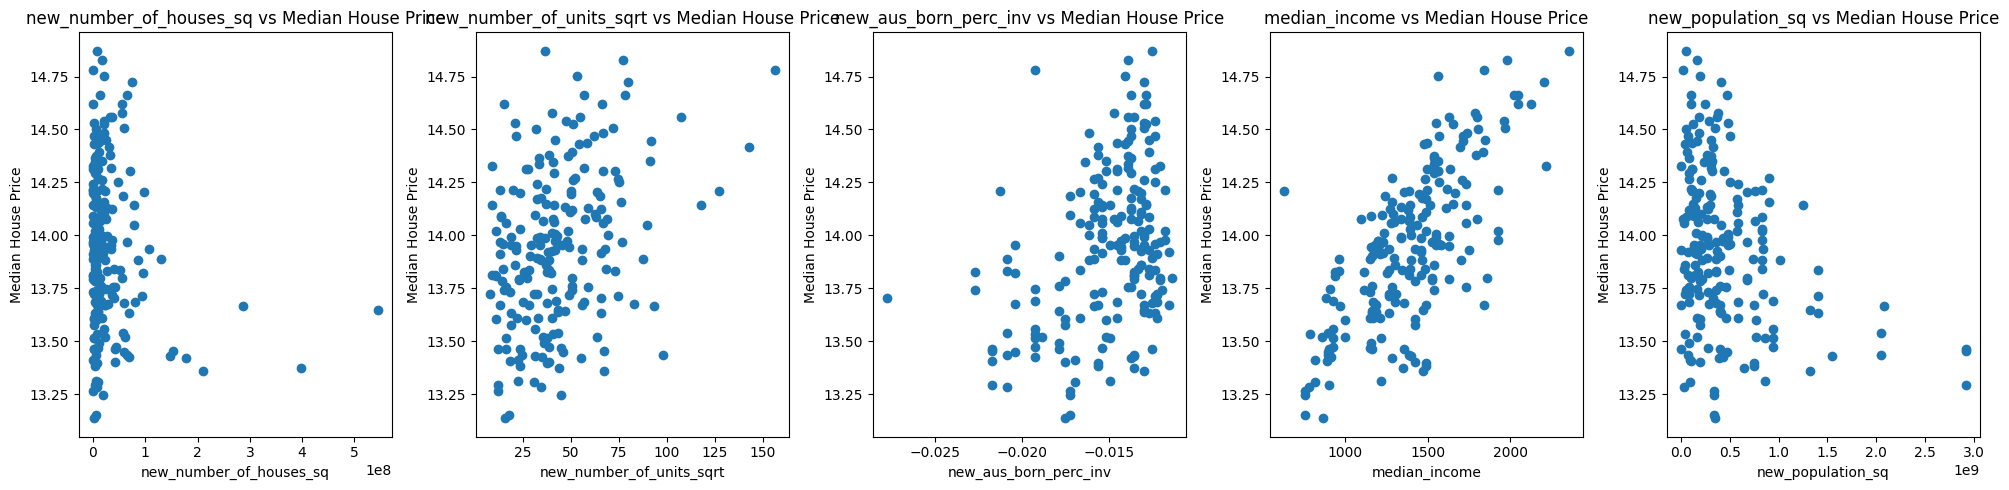

In [ ]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))

for i, var in enumerate(features_inv):
    ax = axes[i]
    ax.scatter(suburb[var], suburb['new_median_house_price_log'])
    ax.set_xlabel(var)
    ax.set_ylabel('Median House Price')
    ax.set_title(f'{var} vs Median House Price')

plt.tight_layout()
plt.show()

### median_income

Lastly, several transformations were tested on the `median_income` but all these transformations weakened the relationship with the target variable. As a result, no transformation was applied to median_income.

In [ ]:
suburb['new_median_income_log'] = np.log(suburb['median_income'])
suburb['new_median_income_sqrt'] = np.sqrt(suburb['median_income'])
suburb['new_median_income_sq'] = suburb['median_income']**2
suburb['new_median_income_cu'] = suburb['median_income']**3


features_log = ['new_number_of_houses_sq', 'new_number_of_units_sqrt', 'new_aus_born_perc_inv', 'new_median_income_log', 'new_population_sq']
features_sqrt = ['new_number_of_houses_sq', 'new_number_of_units_sqrt', 'new_aus_born_perc_inv', 'new_median_income_sqrt', 'new_population_sq']
features_sq = ['new_number_of_houses_sq', 'new_number_of_units_sqrt', 'new_aus_born_perc_inv', 'new_median_income_sq', 'new_population_sq']
features_cu = ['new_number_of_houses_sq', 'new_number_of_units_sqrt', 'new_aus_born_perc_inv', 'new_median_income_cu', 'new_population_sq']

In [ ]:
target = 'new_median_house_price_log'

corr = find_corr(features_log, target)
print('Corr: ','\n', corr,'\n')

corr = find_corr(features_sqrt, target)
print('Corr: ','\n', corr,'\n')

corr = find_corr(features_sq, target)
print('Corr: ','\n', corr,'\n')

corr = find_corr(features_cu, target)
print('Corr: ','\n', corr,'\n')

Corr:  
 new_number_of_houses_sq    -0.1697
new_number_of_units_sqrt    0.3405
new_aus_born_perc_inv       0.3642
new_median_income_log       0.7033
new_population_sq          -0.3217
Name: new_median_house_price_log, dtype: float64 

Corr:  
 new_number_of_houses_sq    -0.1697
new_number_of_units_sqrt    0.3405
new_aus_born_perc_inv       0.3642
new_median_income_sqrt      0.7142
new_population_sq          -0.3217
Name: new_median_house_price_log, dtype: float64 

Corr:  
 new_number_of_houses_sq    -0.1697
new_number_of_units_sqrt    0.3405
new_aus_born_perc_inv       0.3642
new_median_income_sq        0.7162
new_population_sq          -0.3217
Name: new_median_house_price_log, dtype: float64 

Corr:  
 new_number_of_houses_sq    -0.1697
new_number_of_units_sqrt    0.3405
new_aus_born_perc_inv       0.3642
new_median_income_cu        0.6959
new_population_sq          -0.3217
Name: new_median_house_price_log, dtype: float64 



In [ ]:
r2_log = find_r2(features_log, 'new_median_house_price_log', suburb)
print(f"R-squared for log transformation: {r2_log}")

r2_power = find_r2(features_sqrt, 'new_median_house_price_log', suburb)
print(f"R-squared for square root transformation: {r2_power}")

r2_power = find_r2(features_cbrt, 'new_median_house_price_log', suburb)
print(f"R-squared for cubic root transformation: {r2_power}")

r2_power = find_r2(features_sq, 'new_median_house_price_log', suburb)
print(f"R-squared for square transformation: {r2_power}")


R-squared for log transformation: 0.6477565806071206
R-squared for square root transformation: 0.6564046354218955
R-squared for cubic root transformation: 0.6634202521948582
R-squared for square transformation: 0.6519993103436301


### new corr

Below is a comparison of the correlations before and after transformations. All correlations were stronger after the transformations. The next step is to scale all the features to ensure they have the same range, as required by the documentation.

In [ ]:
# original
variables = ['number_of_houses', 'number_of_units', 'aus_born_perc', 'median_income', 'population']

correlations = suburb[variables + ['median_house_price']].corr()
target_corr = correlations['median_house_price'].drop('median_house_price')

print("Pearson Correlation Coefficients with Target Variable:\n")
print(target_corr)

Pearson Correlation Coefficients with Target Variable:

number_of_houses   -0.104490
number_of_units     0.343858
aus_born_perc       0.303860
median_income       0.719384
population         -0.287242
Name: median_house_price, dtype: float64


In [ ]:
# after transform
features = ['new_number_of_houses_sq', 'new_number_of_units_sqrt',
               'new_aus_born_perc_inv', 'median_income', 'new_population_sq']

correlations = suburb[features + ['new_median_house_price_log']].corr()
target_corr = correlations['new_median_house_price_log'].drop('new_median_house_price_log')

print("Pearson Correlation Coefficients with Target Variable:\n")
print(target_corr)

Pearson Correlation Coefficients with Target Variable:

new_number_of_houses_sq    -0.169665
new_number_of_units_sqrt    0.340478
new_aus_born_perc_inv       0.364207
median_income               0.719822
new_population_sq          -0.321655
Name: new_median_house_price_log, dtype: float64


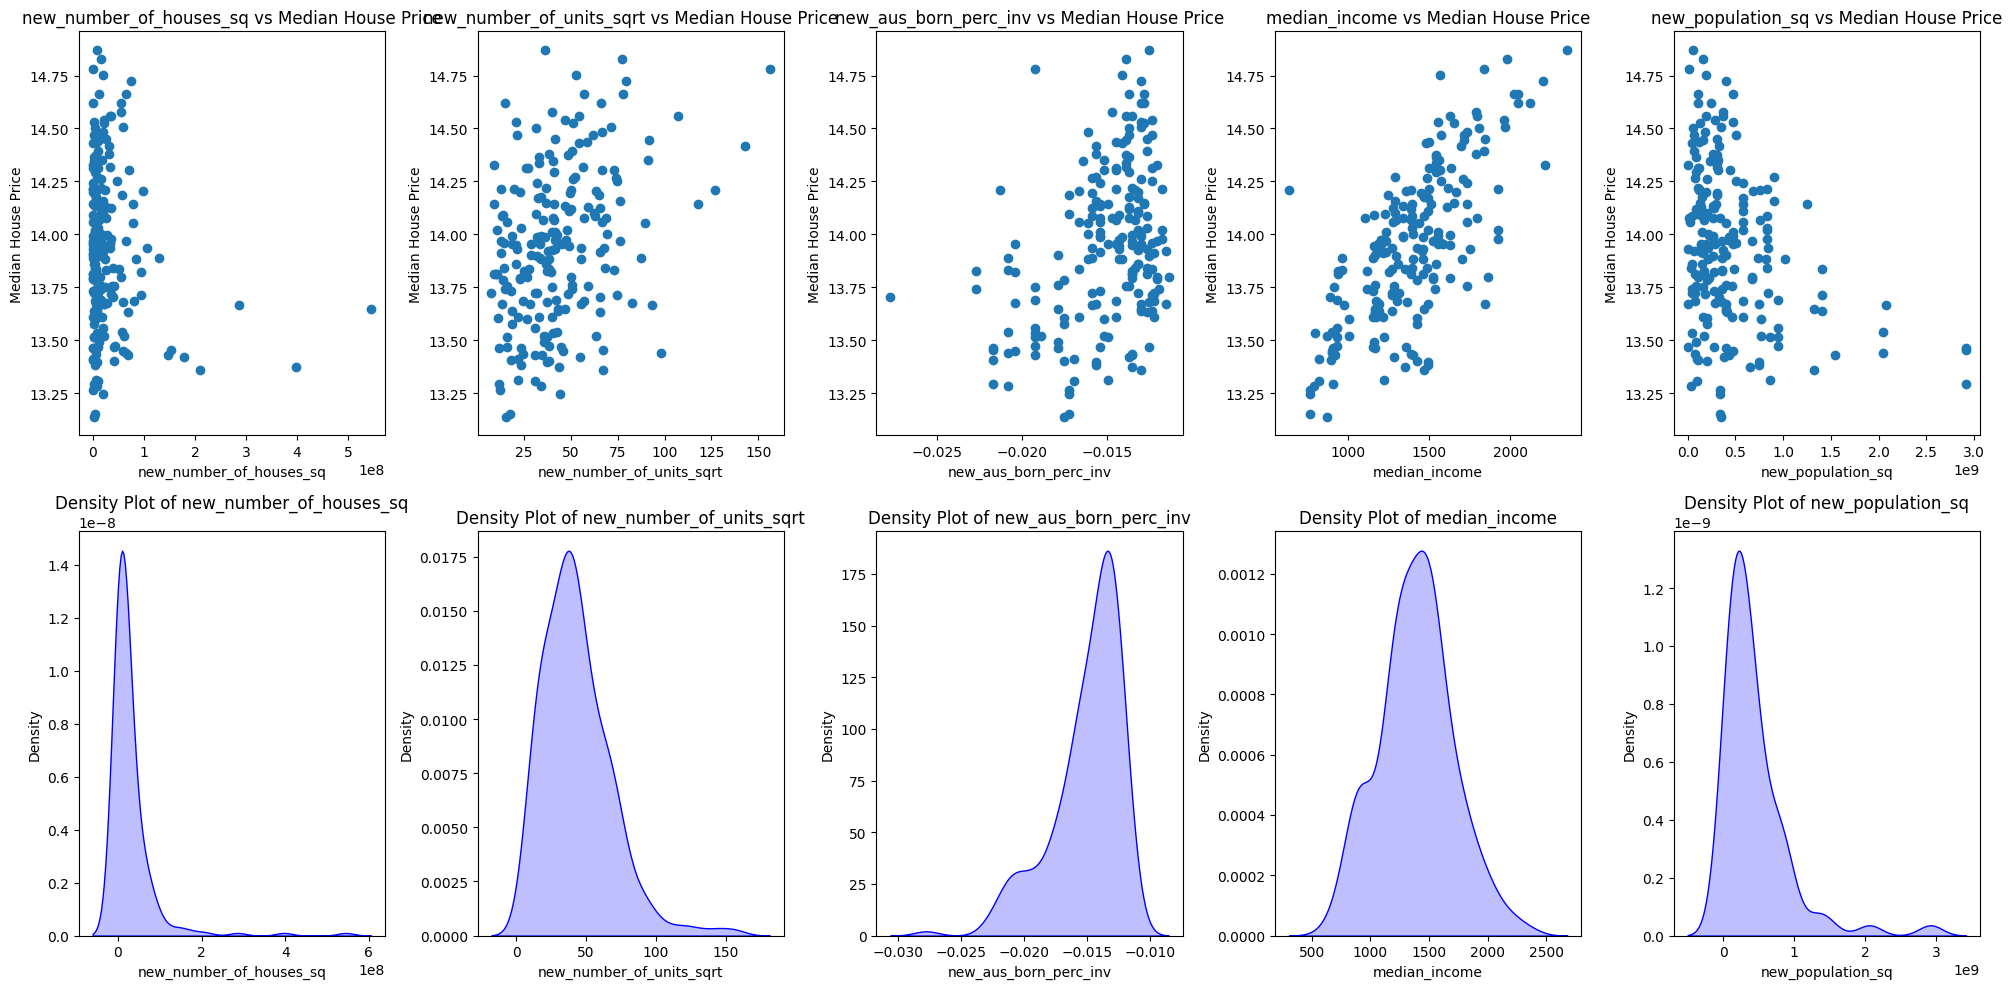

In [ ]:
# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))

# Scatter plots
for i, var in enumerate(features):
    ax = axes[0, i]
    ax.scatter(suburb[var], suburb['new_median_house_price_log'])
    ax.set_xlabel(var)
    ax.set_ylabel('Median House Price')
    ax.set_title(f'{var} vs Median House Price')

# Density plots
for i, var in enumerate(features):
    ax = axes[1, i]
    sns.kdeplot(suburb[var], ax=ax, color='blue', fill=True)
    ax.set_xlabel(var)
    ax.set_ylabel('Density')
    ax.set_title(f'Density Plot of {var}')

plt.tight_layout()
plt.show()


## Scaling

To scale the features, both `Min-Max` scaling and `Normalization` were tested. Using Min-Max scaling, the range of all features was successfully bounded between 0 and 1, whereas normalization still resulted in differing ranges due to the presence of outliers in some columns.

After confirming that scaling had no effect on the correlations observed in the previous part, Min-Max scaling was adopted.

### minmax

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Apply Min-Max scaling to all features
suburb_minmax = suburb.copy()
suburb_minmax[features] = scaler.fit_transform(suburb[features])


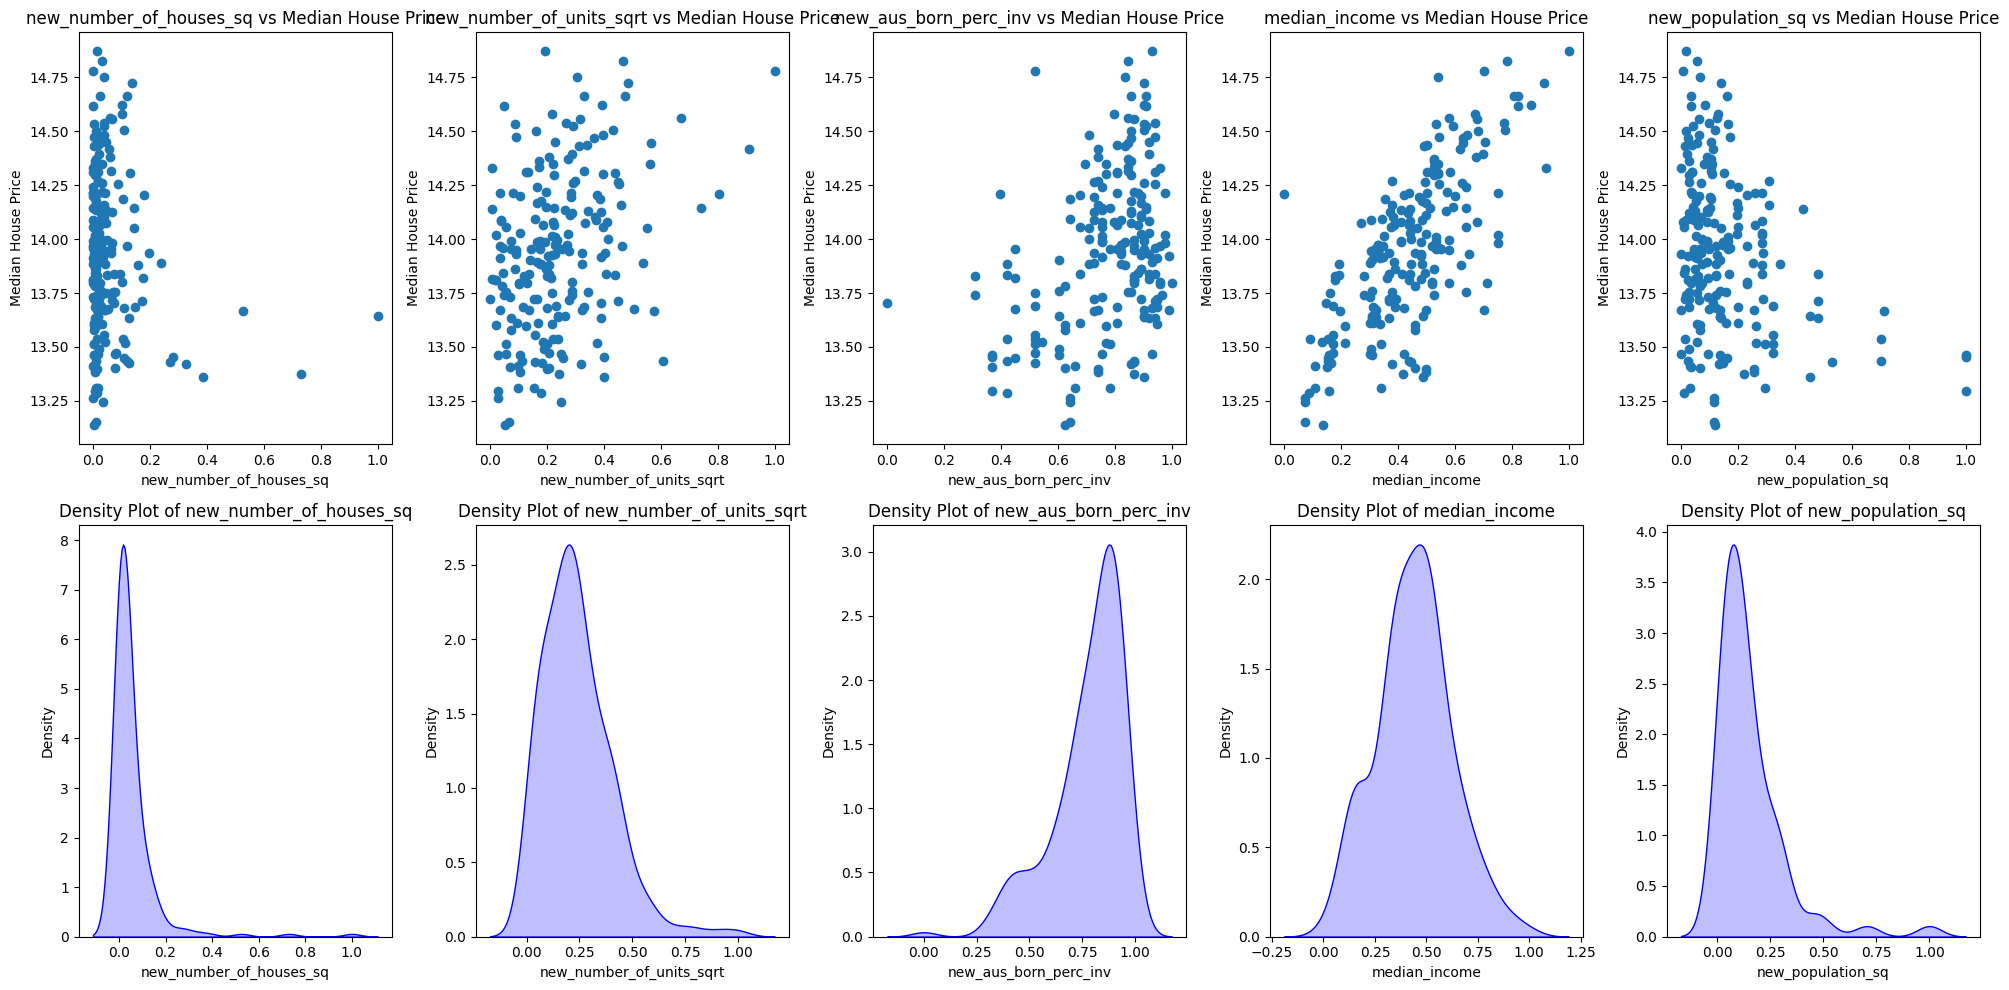

In [ ]:
# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))

# Scatter plots
for i, var in enumerate(features):
    ax = axes[0, i]
    ax.scatter(suburb_minmax[var], suburb_minmax['new_median_house_price_log'])
    ax.set_xlabel(var)
    ax.set_ylabel('Median House Price')
    ax.set_title(f'{var} vs Median House Price')

# Density plots
for i, var in enumerate(features):
    ax = axes[1, i]
    sns.kdeplot(suburb_minmax[var], ax=ax, color='blue', fill=True)
    ax.set_xlabel(var)
    ax.set_ylabel('Density')
    ax.set_title(f'Density Plot of {var}')

plt.tight_layout()
plt.show()


In [ ]:
# after transform
features = ['new_number_of_houses_sq', 'new_number_of_units_sqrt',
               'new_aus_born_perc_inv', 'median_income', 'new_population_sq']

correlations = suburb[features + ['new_median_house_price_log']].corr()
target_corr = correlations['new_median_house_price_log'].drop('new_median_house_price_log')
target_corr

new_number_of_houses_sq    -0.169665
new_number_of_units_sqrt    0.340478
new_aus_born_perc_inv       0.364207
median_income               0.719822
new_population_sq          -0.321655
Name: new_median_house_price_log, dtype: float64

### normalization

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Apply normalization to all features
suburb_normalized = suburb.copy()
suburb_normalized[features] = scaler.fit_transform(suburb[features])

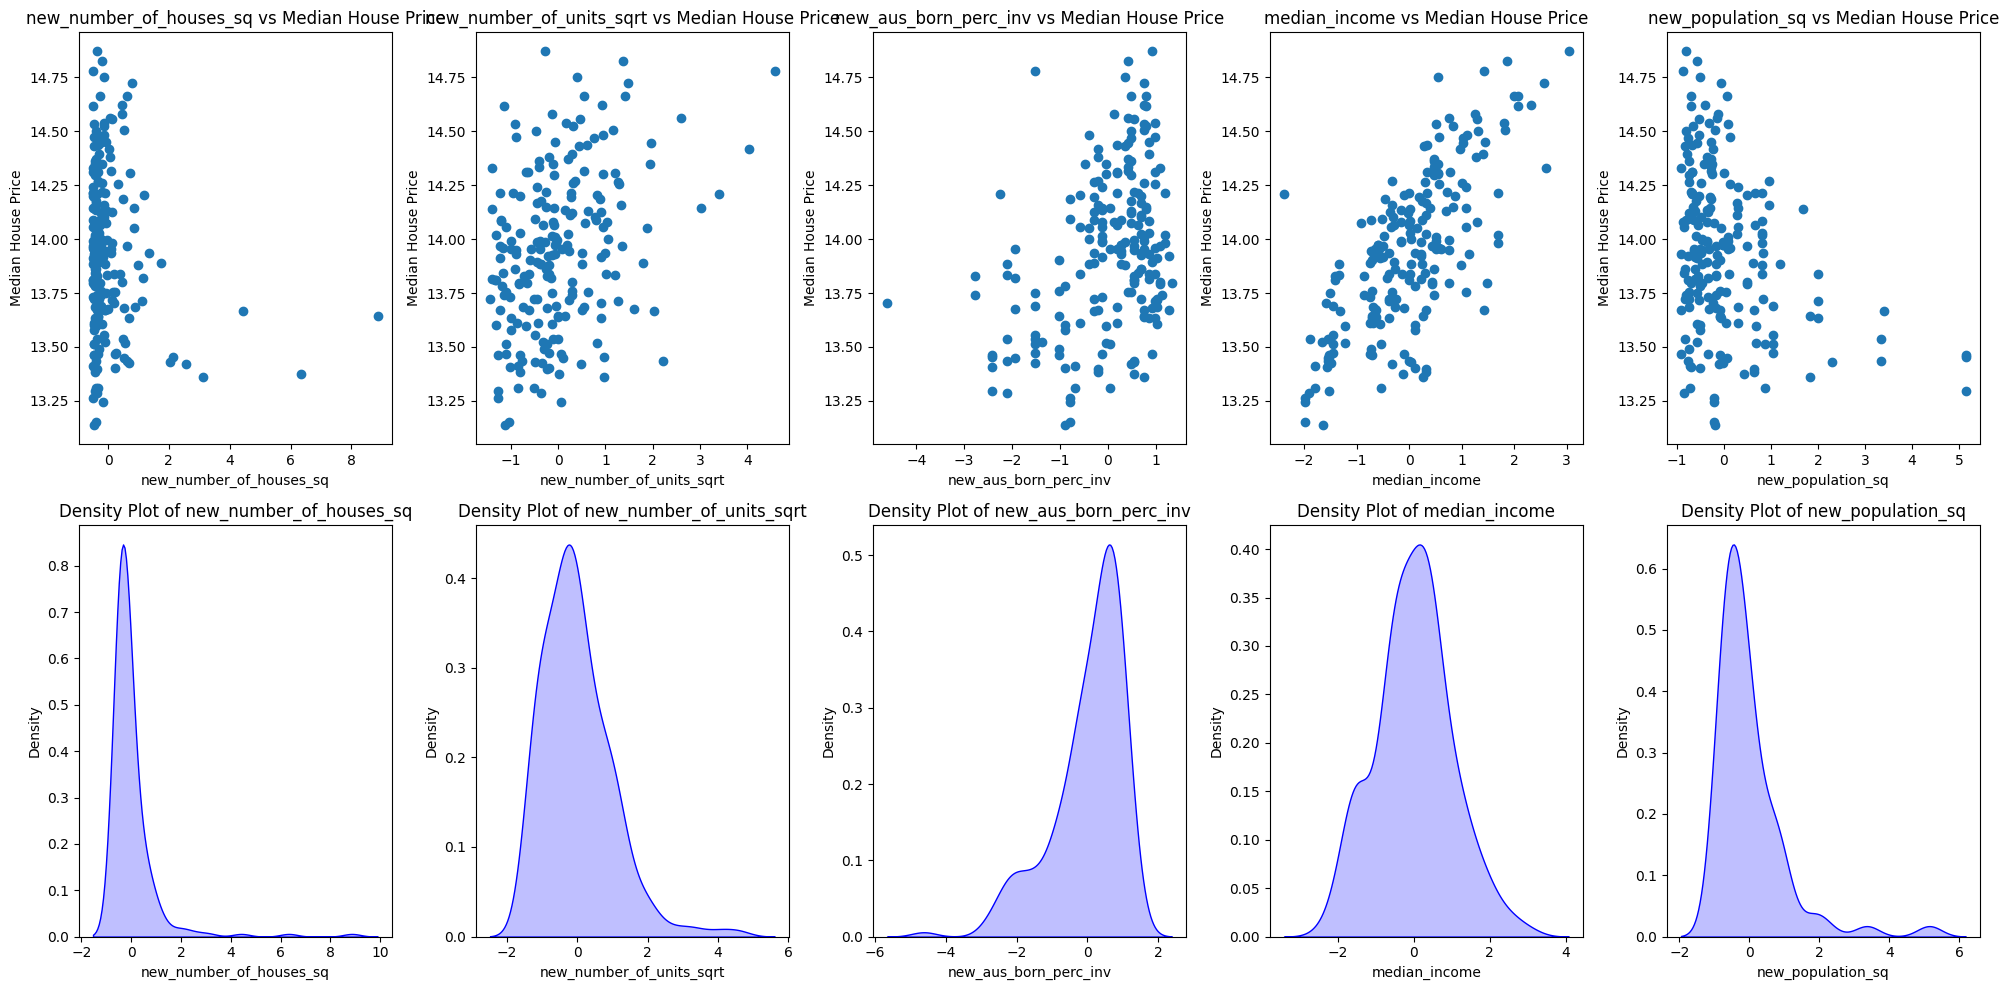

In [ ]:
# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))

# Scatter plots
for i, var in enumerate(features):
    ax = axes[0, i]
    ax.scatter(suburb_normalized[var], suburb_normalized['new_median_house_price_log'])
    ax.set_xlabel(var)
    ax.set_ylabel('Median House Price')
    ax.set_title(f'{var} vs Median House Price')

# Density plots
for i, var in enumerate(features):
    ax = axes[1, i]
    sns.kdeplot(suburb_normalized[var], ax=ax, color='blue', fill=True)
    ax.set_xlabel(var)
    ax.set_ylabel('Density')
    ax.set_title(f'Density Plot of {var}')

plt.tight_layout()
plt.show()


In [ ]:
# after transform
features = ['new_number_of_houses_sq', 'new_number_of_units_sqrt',
               'new_aus_born_perc_inv', 'median_income', 'new_population_sq']

correlations = suburb_normalized[features + ['new_median_house_price_log']].corr()
target_corr = correlations['new_median_house_price_log'].drop('new_median_house_price_log')
target_corr

new_number_of_houses_sq    -0.169665
new_number_of_units_sqrt    0.340478
new_aus_born_perc_inv       0.364207
median_income               0.719822
new_population_sq          -0.321655
Name: new_median_house_price_log, dtype: float64

## Conculsion

In conclusion, after implementing various transformation approaches across different columns, we decided not to transform the `median income` data. Instead, we performed the following transformations on the variables:
* Log transformation on `median house price`, which is the target.
* Square transformation on `number of houses` and `population`.
* Square root transformation on `number of units`.
* Inverse transformation on `aus born prec`.

Additionally, we applied both `min-max scaling` and `normalization` techniques to standardise the data to the same scale. For linear model training, if the data needs to be in positive values, we recommend using the `min-max scaling` approach for data scaling.



<div class="alert alert-block alert-warning">

# 3. Reference  <a class="Reference" name="Reference"></a>
    
</div>

**Dirty data:**

[1] How to change Datetime Format in Pandas, https://saturncloud.io/blog/how-to-change-datetime-format-in-pandas/

[2] pandas.DataFrame.apply, https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html

[3] numpy.linalg.lstsq, https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html

[4] numpy.linalg.sovle, https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html

[5]Least square in linear models with algebra and python: https://medium.com/@marcozaninitaly/least-square-in-linear-models-with-algebra-and-python-279e3d82e20c

[6]Create identity matrix with `eye`: https://www.geeksforgeeks.org/numpy-eye-python/

[7] How to get the shortest path: https://stackoverflow.com/questions/59343417/how-to-get-the-shortest-path-in-a-weighted-graph-with-networkx


**Outlier data:**

[1] hampel 1.0.2, https://pypi.org/project/hampel/

**Missing data:**

[1] Change datatype into categorical data: https://pandas.pydata.org/docs/user_guide/categorical.html
